In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from sklearn.ensemble import HistGradientBoostingRegressor, GradientBoostingRegressor
from sklearn.tree import plot_tree
import scipy
import math
import matplotlib.gridspec as gridspec
import statsmodels.api as sm
import statsmodels.formula.api as smf
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Multiply, Embedding, Add, Concatenate, Flatten,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras import regularizers
from sklearn.preprocessing import MinMaxScaler
from  sklearn.metrics import mean_poisson_deviance
from  sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.decomposition import PCA
from sklearn.ensemble import AdaBoostClassifier
from scipy.stats import spearmanr
plt.rcParams['figure.figsize'] = [15, 6]
plt.rcParams['figure.autolayout'] = True

In questo notebook si applicano diversi metodi per prezzare delle polizze danni nel settore automobilistico, applivati al dataset freMTPL2freq di CASdataset. Nello specifico ci si concentra sull'assunzione di compund poisson per l'intero portafoglio perdite e si procede prezzando la componete la parte relativa al: $$E^\mathbb{P}[N]$$
Suddividendolo nelle diverse categorie di rischio, a seconda dei regressori si determinano i  $$E^\mathbb{P}[N_i]$$ associati ad ogni esposizione.
Si parte con una breve analisi grafica per capire la struttura del dataset

In [2]:
DATASET = pd.read_csv("freMTPL2freq.csv")
print(DATASET.iloc[0:10,:])

   IDpol  ClaimNb  Exposure Area  VehPower  VehAge  DrivAge  BonusMalus  \
0    1.0        1      0.10    D         5       0       55          50   
1    3.0        1      0.77    D         5       0       55          50   
2    5.0        1      0.75    B         6       2       52          50   
3   10.0        1      0.09    B         7       0       46          50   
4   11.0        1      0.84    B         7       0       46          50   
5   13.0        1      0.52    E         6       2       38          50   
6   15.0        1      0.45    E         6       2       38          50   
7   17.0        1      0.27    C         7       0       33          68   
8   18.0        1      0.71    C         7       0       33          68   
9   21.0        1      0.15    B         7       0       41          50   

  VehBrand   VehGas  Density Region  
0      B12  Regular     1217    R82  
1      B12  Regular     1217    R82  
2      B12   Diesel       54    R22  
3      B12   Diesel   

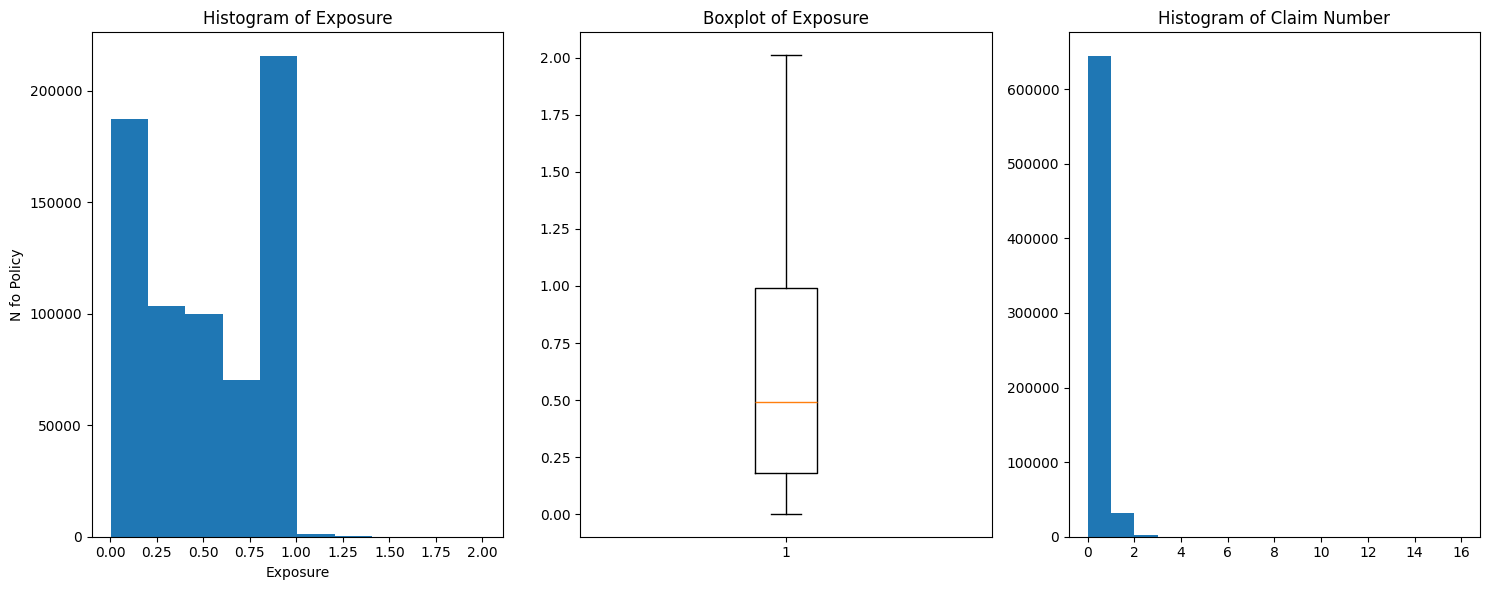

In [3]:
fig, ax = plt.subplots(nrows = 1, ncols = 3)

ax[0].hist(DATASET["Exposure"],bins=10)
ax[0].set_title("Histogram of Exposure")
ax[0].set_xlabel("Exposure")
ax[0].set_ylabel("N fo Policy")

ax[1].boxplot(DATASET["Exposure"])
ax[1].set_title("Boxplot of Exposure")

ax[2].hist(DATASET["ClaimNb"], bins=16)
ax[2].set_title("Histogram of Claim Number")
plt.show(block= True)

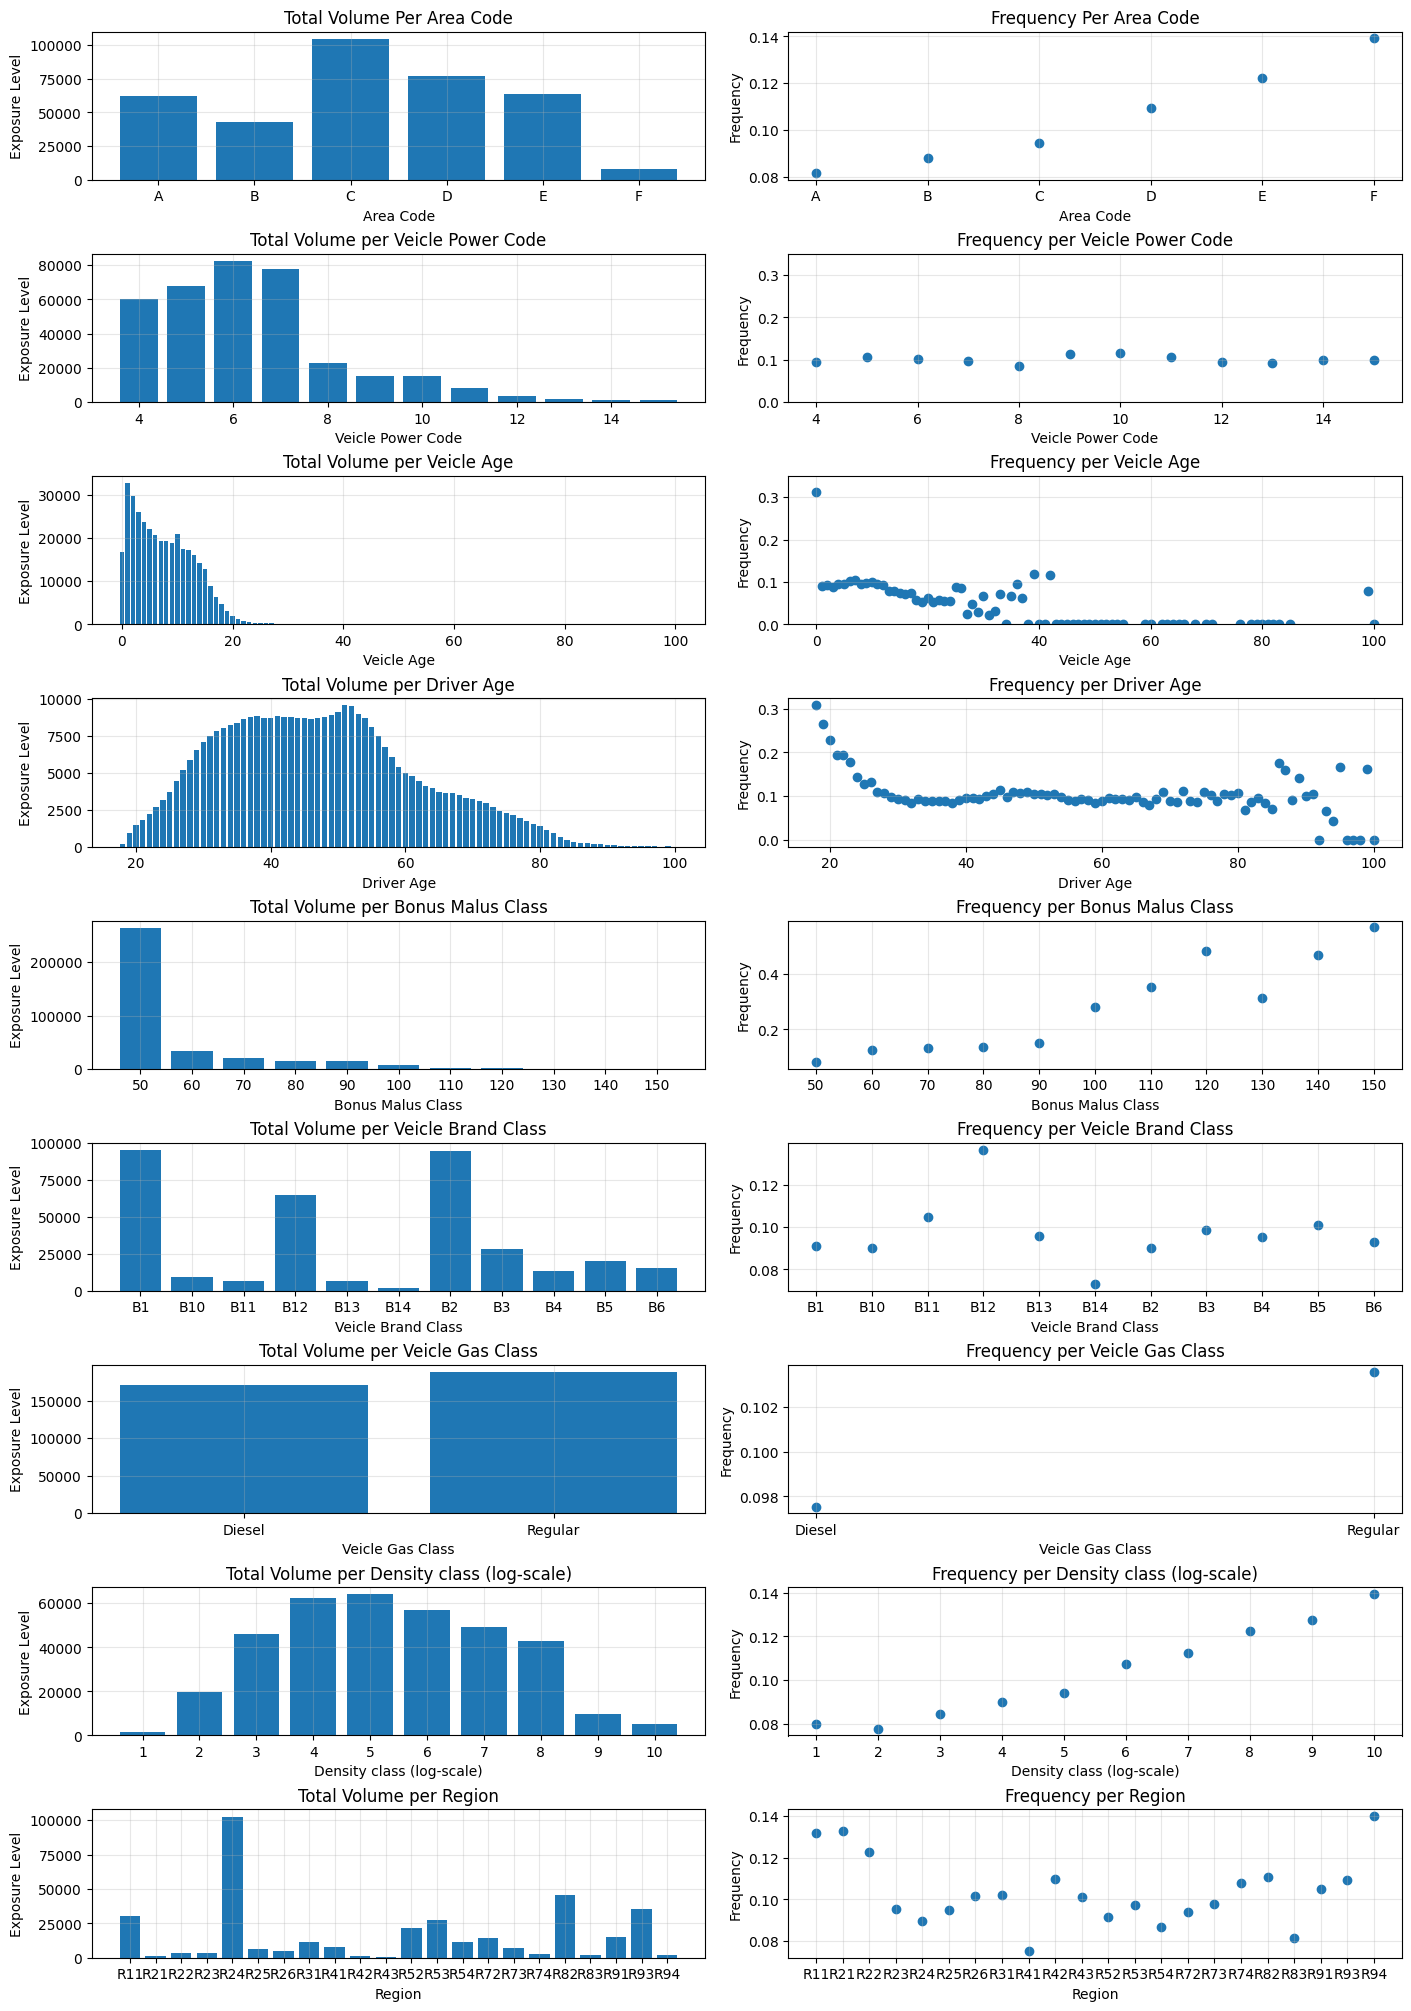

In [4]:
pivot = pd.pivot_table(DATASET,values=["ClaimNb","Exposure"], index="Area",aggfunc='sum')
fig, ax = plt.subplots(nrows = 9, ncols = 2,figsize=(14, 20), constrained_layout=True)
ax[0,0].bar(pivot.index ,pivot["Exposure"])
ax[0,0].set_title("Total Volume Per Area Code")
ax[0,0].set_xlabel("Area Code")
ax[0,0].set_ylabel("Exposure Level")
ax[0,0].grid(alpha=0.3)

ax[0,1].scatter(pivot.index,pivot["ClaimNb"]/ pivot["Exposure"])
ax[0,1].set_title("Frequency Per Area Code")
ax[0,1].set_xlabel("Area Code")
ax[0,1].set_ylabel("Frequency")
ax[0,1].grid(alpha=0.3)

pivot = pd.pivot_table(DATASET,values=["ClaimNb","Exposure"], index="VehPower",aggfunc='sum')

ax[1,0].bar(pivot.index ,pivot["Exposure"])
ax[1,0].set_title("Total Volume per Veicle Power Code")
ax[1,0].set_xlabel("Veicle Power Code")
ax[1,0].set_ylabel("Exposure Level")
ax[1,0].grid(alpha=0.3)

ax[1,1].scatter(pivot.index, pivot["ClaimNb"]/pivot["Exposure"])
ax[1,1].set_title("Frequency per Veicle Power Code")
ax[1,1].set_xlabel("Veicle Power Code")
ax[1,1].set_ylabel("Frequency")
ax[1,1].grid(alpha=0.3)
ax[1,1].set_ylim(bottom =.0,top=.35 )

pivot = pd.pivot_table(DATASET,values=["ClaimNb","Exposure"], index="VehAge",aggfunc='sum')
ax[2,0].bar(pivot.index ,pivot["Exposure"])
ax[2,0].set_title("Total Volume per Veicle Age")
ax[2,0].set_xlabel("Veicle Age")
ax[2,0].set_ylabel("Exposure Level")
ax[2,0].grid(alpha=0.3)

ax[2,1].scatter(pivot.index, pivot["ClaimNb"]/pivot["Exposure"])
ax[2,1].set_title("Frequency per Veicle Age")
ax[2,1].set_xlabel("Veicle Age")
ax[2,1].set_ylabel("Frequency")
ax[2,1].grid(alpha=0.3)
ax[2,1].set_ylim(bottom =.0,top=.35 )

pivot = pd.pivot_table(DATASET,values=["ClaimNb","Exposure"], index="DrivAge",aggfunc='sum')
ax[3,0].bar(pivot.index ,pivot["Exposure"])
ax[3,0].set_title("Total Volume per Driver Age")
ax[3,0].set_xlabel("Driver Age")
ax[3,0].set_ylabel("Exposure Level")
ax[3,0].grid(alpha=0.3)

ax[3,1].scatter(pivot.index, pivot["ClaimNb"]/pivot["Exposure"])
ax[3,1].set_title("Frequency per Driver Age")
ax[3,1].set_xlabel("Driver Age")
ax[3,1].set_ylabel("Frequency")
ax[3,1].grid(alpha=0.3)

pivot = pd.pivot_table(DATASET,values=["ClaimNb","Exposure"], index="BonusMalus",aggfunc='sum')
pivot.reset_index(inplace=True)
bins = [50,60,70,80,90,100,110,120,130,140,150,10000]
label = ["50","60","70","80","90","100","110","120","130","140","150"]
pivot["BonusMalus"] = pd.cut(pivot["BonusMalus"],bins= bins, labels= label, include_lowest=True,right=False)
pivot = pd.pivot_table(pivot,values=["ClaimNb","Exposure"], index="BonusMalus",aggfunc='sum')
ax[4,0].bar(pivot.index ,pivot["Exposure"])
ax[4,0].set_title("Total Volume per Bonus Malus Class")
ax[4,0].set_xlabel("Bonus Malus Class")
ax[4,0].set_ylabel("Exposure Level")
ax[4,0].grid(alpha=0.3)

ax[4,1].scatter(pivot.index, pivot["ClaimNb"]/pivot["Exposure"])
ax[4,1].set_title("Frequency per Bonus Malus Class")
ax[4,1].set_xlabel("Bonus Malus Class")
ax[4,1].set_ylabel("Frequency")
ax[4,1].grid(alpha=0.3)

pivot = pd.pivot_table(DATASET,values=["ClaimNb","Exposure"], index="VehBrand",aggfunc='sum')
ax[5,0].bar(pivot.index ,pivot["Exposure"])
ax[5,0].set_title("Total Volume per Veicle Brand Class")
ax[5,0].set_xlabel("Veicle Brand Class")
ax[5,0].set_ylabel("Exposure Level")
ax[5,0].grid(alpha=0.3)

ax[5,1].scatter(pivot.index, pivot["ClaimNb"]/pivot["Exposure"])
ax[5,1].set_title("Frequency per Veicle Brand Class")
ax[5,1].set_xlabel("Veicle Brand Class")
ax[5,1].set_ylabel("Frequency")
ax[5,1].grid(alpha=0.3)

pivot = pd.pivot_table(DATASET,values=["ClaimNb","Exposure"], index="VehGas",aggfunc='sum')
ax[6,0].bar(pivot.index ,pivot["Exposure"])
ax[6,0].set_title("Total Volume per Veicle Gas Class")
ax[6,0].set_xlabel("Veicle Gas Class")
ax[6,0].set_ylabel("Exposure Level")
ax[6,0].grid(alpha=0.3)

ax[6,1].scatter(pivot.index, pivot["ClaimNb"]/pivot["Exposure"])
ax[6,1].set_title("Frequency per Veicle Gas Class")
ax[6,1].set_xlabel("Veicle Gas Class")
ax[6,1].set_ylabel("Frequency")
ax[6,1].grid(alpha=0.3)

pivot = pd.pivot_table(DATASET,values=["ClaimNb","Exposure"], index="Density",aggfunc='sum')
pivot.reset_index(inplace=True)
pivot["Density"] = np.log(pivot["Density"])
bins = [1,2,3,4,5,6,7,8,9,10,1000]
label = ["1","2","3","4","5","6","7","8","9","10"]
pivot["Density"] = pd.cut(pivot["Density"],bins= bins, labels= label, include_lowest=True,right=False)
pivot = pd.pivot_table(pivot,values=["ClaimNb","Exposure"], index="Density",aggfunc='sum')
ax[7,0].bar(pivot.index ,pivot["Exposure"])
ax[7,0].set_title("Total Volume per Density class (log-scale)")
ax[7,0].set_xlabel("Density class (log-scale)")
ax[7,0].set_ylabel("Exposure Level")
ax[7,0].grid(alpha=0.3)

ax[7,1].scatter(pivot.index, pivot["ClaimNb"]/pivot["Exposure"])
ax[7,1].set_title("Frequency per Density class (log-scale)")
ax[7,1].set_xlabel("Density class (log-scale)")
ax[7,1].set_ylabel("Frequency")
ax[7,1].grid(alpha=0.3)

pivot = pd.pivot_table(DATASET,values=["ClaimNb","Exposure"], index="Region",aggfunc='sum')
ax[8,0].bar(pivot.index ,pivot["Exposure"])
ax[8,0].set_title("Total Volume per Region")
ax[8,0].set_xlabel("Region")
ax[8,0].set_ylabel("Exposure Level")
ax[8,0].grid(alpha=0.3)

ax[8,1].scatter(pivot.index, pivot["ClaimNb"]/pivot["Exposure"])
ax[8,1].set_title("Frequency per Region")
ax[8,1].set_xlabel("Region")
ax[8,1].set_ylabel("Frequency")
ax[8,1].grid(alpha=0.3)

plt.show(block = True)


Preprocessing dei regressori: Codifica categoriale di variabili: Area, VehPower, VehAge e DrivAge. Raggruppamento delle classi di età e potenza per ridurre la granularità. Log-trasformazione applicata a Density.

Creazione del training set (90% dei dati) e test set (10% dei dati) con campionamento casuale.

In [5]:
#Preprocessing dei regressori
DATASET["AreaGLM"] = DATASET["Area"].astype("category").cat.codes
DATASET["VehPowerGLM"] = np.minimum(DATASET["VehPower"], 9).astype("category")
VehAge = np.concatenate([np.linspace(0,110, num=111).reshape(-1,1), np.array([1]+ [2 for i in range(0,10)]+[3 for i in range(0,100)]).reshape(-1,1)],axis=1)
DATASET["VehAge"] = pd.DataFrame(VehAge[DATASET["VehAge"],1], dtype="int")[0].astype("category")
DriveAge = np.concatenate([np.linspace(18,100,83).reshape(-1,1),np.array([1 for i in range(21-18)]+[2 for i in range(26-21)]
                           +[3 for i in range(31-26)] +[4 for i in range(41-31)]+[5 for i in range(51-41)]+[6 for i in range(71-51)]
                           +[7 for i in range(101-71)]).reshape(-1,1) ] ,axis=1)
DATASET["DrivAge"] = pd.DataFrame(DriveAge[DATASET["DrivAge"].values-18,1], dtype="int")[0].astype("category")
DATASET["BonusMalus"] = np.minimum(DATASET["BonusMalus"], 150)
DATASET["Density"] = np.log(DATASET["Density"])

random.seed(100)
ll = random.sample(range(DATASET.shape[0]-1), round(DATASET.shape[0]*0.9 ))
train = DATASET.loc[ll,:]
test =  DATASET.drop(index=ll)


Costruzione del moedello GLM1

In [6]:
#costruzione modello GLM
try:
    model = smf.glm(formula="ClaimNb ~ VehPowerGLM + C(VehAge, Treatment(reference = 2)) + C(DrivAge, Treatment(reference = 5)) + BonusMalus + VehBrand + VehGas + Density + C(Region, Treatment(reference = 'R24')) + AreaGLM" ,
                family = sm.families.Poisson(), data = train , offset = np.log(train["Exposure"]))
except Exception as e:
    print("errore")
    print(e)
start = time.time()
model1 = model.fit()
end = time.time()
tempo_mod1 = end-start
prediction1 = model1.predict(test, offset= np.log(test["Exposure"]))
print(model1.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                ClaimNb   No. Observations:               610212
Model:                            GLM   Df Residuals:                   610163
Model Family:                 Poisson   Df Model:                           48
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.2701e+05
Date:                Wed, 12 Nov 2025   Deviance:                   1.9166e+05
Time:                        08:35:13   Pearson chi2:                 1.43e+06
No. Iterations:                     7   Pseudo R-squ. (CS):            0.01664
Covariance Type:            nonrobust                                         
                                                   coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

Confronto risultati del modello con dati reali

In [7]:
print(f"---Frequenze Empiriche sul Training Set---")
print(f"Numero Claim Osservato 0: {np.mean(train['ClaimNb'].values == 0)}")
print(f"Numero Claim Osservato 1: {np.mean(train['ClaimNb'].values == 1)}")
print(f"Numero Claim Osservato 2: {np.mean(train['ClaimNb'].values == 2)}")
print(f"Numero Claim Osservato 3: {np.mean(train['ClaimNb'].values == 3)}")
print(f"Numero Claim Osservato >=4: {np.mean(train['ClaimNb'].values >= 4)}")

print(f"---Frequenze Previste da modello 1 sul Training Set---")
print(f"Numero Claim Osservato 0: {np.mean(np.exp(-model1.mu))}")
print(f"Numero Claim Osservato 1: {np.mean(np.exp(-model1.mu) * model1.mu)}")
print(f"Numero Claim Osservato 2: {np.mean(np.exp(-model1.mu) * model1.mu**2 /2)}")
print(f"Numero Claim Osservato 3: {np.mean(np.exp(-model1.mu) * model1.mu**3 /6)}")
print(f"Numero Claim Osservato >=4: {np.mean(1 - np.exp(-model1.mu) - np.exp(-model1.mu) * model1.mu - np.exp(-model1.mu) * model1.mu**2 /2 - np.exp(-model1.mu) * model1.mu**3 /6 )}")

print(f"---Frequenze Empiriche sul Test Set---")
print(f"Numero Claim Osservato 0: {np.mean(test['ClaimNb'].values == 0)}")
print(f"Numero Claim Osservato 1: {np.mean(test['ClaimNb'].values == 1)}")
print(f"Numero Claim Osservato 2: {np.mean(test['ClaimNb'].values == 2)}")
print(f"Numero Claim Osservato 3: {np.mean(test['ClaimNb'].values == 3)}")
print(f"Numero Claim Osservato >=4: {np.mean(test['ClaimNb'].values >= 4)}")

print(f"---Frequenze Previste da modello 1 sul Test Set---")
print(f"Numero Claim Osservato 0: {np.mean(np.exp(-prediction1.values))}")
print(f"Numero Claim Osservato 1: {np.mean(np.exp(-prediction1.values) * prediction1.values)}")
print(f"Numero Claim Osservato 2: {np.mean(np.exp(-prediction1.values) * prediction1.values**2 /2)}")
print(f"Numero Claim Osservato 3: {np.mean(np.exp(-prediction1.values) * prediction1.values**3 /6)}")
print(f"Numero Claim Osservato >=4: {np.mean(1 - np.exp(-prediction1.values) - np.exp(-prediction1.values) * prediction1.values - np.exp(-prediction1.values) * prediction1.values**2 /2 - np.exp(-prediction1.values) * prediction1.values**3 /6 )}")


---Frequenze Empiriche sul Training Set---
Numero Claim Osservato 0: 0.9497994139741598
Numero Claim Osservato 1: 0.04739500370363087
Numero Claim Osservato 2: 0.002656453822605914
Numero Claim Osservato 3: 0.0001261856535105832
Numero Claim Osservato >=4: 2.294284609283331e-05
---Frequenze Previste da modello 1 sul Training Set---
Numero Claim Osservato 0: 0.9492482080284157
Numero Claim Osservato 1: 0.04839679272791702
Numero Claim Osservato 2: 0.002229932999288203
Numero Claim Osservato 3: 0.00011584726941031076
Numero Claim Osservato >=4: 9.218974968449616e-06
---Frequenze Empiriche sul Test Set---
Numero Claim Osservato 0: 0.9494550227872746
Numero Claim Osservato 1: 0.048037639562838304
Numero Claim Osservato 2: 0.002404094334891816
Numero Claim Osservato 3: 7.374522499668146e-05
Numero Claim Osservato >=4: 2.9498089998672585e-05
---Frequenze Previste da modello 1 sul Test Set---
Numero Claim Osservato 0: 0.9491954468319087
Numero Claim Osservato 1: 0.048452293912049416
Numero Cl

Anova per vedere apporto dei singoli regressori

In [8]:
regressors = ["VehPowerGLM", " + C(VehAge, Treatment(reference = 2))", "+ C(DrivAge, Treatment(reference = 5))", "+ BonusMalus", "+ VehBrand", "+ VehGas", "+ Density", "+ C(Region, Treatment(reference = 'R24'))", "+ AreaGLM"]
df = []
deviance_diff = []
df_resid = []
deviance = []
for i in range(len(regressors)+1):
    if i == 0:
        reg = str(1)
    else:
        reg = str()
        for j in range(i):
            reg = reg + regressors[j]

    try:
        model = smf.glm(
            formula=f"ClaimNb ~ {reg}",
            family=sm.families.Poisson(), data=train, offset=np.log(train["Exposure"]))
    except Exception as e:
        print("errore")
        print(e)
    model_anova = model.fit()
    if i == 0:
        df.append(model_anova.df_model)
        deviance_diff.append(0)
        df_resid.append(model_anova.df_resid)
        deviance.append(model_anova.deviance)
    else:
        df.append(model_anova.df_model - sum(df))
        deviance_diff.append(deviance[i-1] - model_anova.deviance)
        df_resid.append(model_anova.df_resid)
        deviance.append(model_anova.deviance)


tabella = pd.DataFrame(np.array([df,deviance_diff,df_resid,deviance]).T)
tabella["indici"] = pd.Series(["Null","VehPowerGLM", "VehAgeGLM", "DrivAgeGLM", "BonusMalusGLM", "VehBrand", "VehGas", "Density", "Region", "AreaGLM"])
tabella.set_index(keys="indici", inplace = True)
tabella.columns = ["df","Deviance_diff", "df_resid","Deviance"]
print(tabella)

                 df  Deviance_diff  df_resid       Deviance
indici                                                     
Null            0.0       0.000000  610211.0  201897.289639
VehPowerGLM     5.0     135.894173  610206.0  201761.395466
VehAgeGLM       2.0    4873.450326  610204.0  196887.945140
DrivAgeGLM      6.0     964.369867  610198.0  195923.575273
BonusMalusGLM   1.0    3844.912754  610197.0  192078.662519
VehBrand       10.0      66.342914  610187.0  192012.319605
VehGas          1.0      50.318082  610186.0  191962.001524
Density         1.0     128.167444  610185.0  191833.834080
Region         21.0     173.360848  610164.0  191660.473232
AreaGLM         1.0       1.064408  610163.0  191659.408824


Modello senza AreaGLM (GLM2)

In [9]:
####--------- Costruzione del modello senza AreaGLM ------------
try:
    model = smf.glm(formula="ClaimNb ~ VehPowerGLM + C(VehAge, Treatment(reference = 2)) + C(DrivAge, Treatment(reference = 5)) + BonusMalus + VehBrand + VehGas + Density + C(Region, Treatment(reference = 'R24'))" ,
                family = sm.families.Poisson(), data = train , offset = np.log(train["Exposure"]))
except Exception as e:
    print("errore")
    print(e)
start = time.time()
model2 = model.fit()
end = time.time()
tempo_mod2 = end - start
prediction2 = model2.predict(test, offset= np.log(test["Exposure"]))
print(model2.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                ClaimNb   No. Observations:               610212
Model:                            GLM   Df Residuals:                   610164
Model Family:                 Poisson   Df Model:                           47
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.2701e+05
Date:                Wed, 12 Nov 2025   Deviance:                   1.9166e+05
Time:                        08:37:22   Pearson chi2:                 1.43e+06
No. Iterations:                     7   Pseudo R-squ. (CS):            0.01664
Covariance Type:            nonrobust                                         
                                                   coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

Modello senza AreaGLM e vehBrand (GLM3)

In [10]:
try:
    model = smf.glm(formula="ClaimNb ~ VehPowerGLM + C(VehAge, Treatment(reference = 2)) + C(DrivAge, Treatment(reference = 5)) + BonusMalus  + VehGas + Density + C(Region, Treatment(reference = 'R24'))" ,
                family = sm.families.Poisson(), data = train , offset = np.log(train["Exposure"]))
except Exception as e:
    print("errore")
    print(e)
start = time.time()
model3 = model.fit()
end = time.time()
tempo_mod3 = end - start
prediction3 = model3.predict(test, offset= np.log(test["Exposure"]))
print(model3.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                ClaimNb   No. Observations:               610212
Model:                            GLM   Df Residuals:                   610174
Model Family:                 Poisson   Df Model:                           37
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.2705e+05
Date:                Wed, 12 Nov 2025   Deviance:                   1.9173e+05
Time:                        08:37:41   Pearson chi2:                 1.44e+06
No. Iterations:                     7   Pseudo R-squ. (CS):            0.01652
Covariance Type:            nonrobust                                         
                                                   coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

Confronto GLM1 v GLM2 v GLM3

In [11]:
loss1 = mean_poisson_deviance(train["ClaimNb"],model1.mu )
oos_loss1 = mean_poisson_deviance(test["ClaimNb"], prediction1.values)
print("________________________________________")
print(f"Poisson deviance loss GLM1:{ loss1}")
print(f"Out of Samle Poisson deviance loss GLM1:{ oos_loss1}")

loss2 = mean_poisson_deviance(train["ClaimNb"],model2.mu )
oos_loss2 = mean_poisson_deviance(test["ClaimNb"], prediction2.values)
print("________________________________________")
print(f"Poisson deviance loss GLM1:{ loss2}")
print(f"Out of Samle Poisson deviance loss GLM1:{ oos_loss2}")

loss3 = mean_poisson_deviance(train["ClaimNb"],model3.mu )
oos_loss3 = mean_poisson_deviance(test["ClaimNb"], prediction3.values)
print("________________________________________")
print(f"Poisson deviance loss GLM1:{ loss3}")
print(f"Out of Samle Poisson deviance loss GLM1:{ oos_loss2}")


________________________________________
Poisson deviance loss GLM1:0.3140865942061523
Out of Samle Poisson deviance loss GLM1:0.31788823943412947
________________________________________
Poisson deviance loss GLM1:0.31408833853090296
Out of Samle Poisson deviance loss GLM1:0.3178891747493038
________________________________________
Poisson deviance loss GLM1:0.31420499554219267
Out of Samle Poisson deviance loss GLM1:0.3178891747493038


In [12]:
tab_conf =pd.concat([pd.DataFrame(np.array([tempo_mod1,tempo_mod2,tempo_mod3])),
                           pd.DataFrame(np.array([model1.df_model,model2.df_model,model3.df_model])),
                           pd.DataFrame(np.array([model1.aic,model2.aic,model3.aic])),
                           pd.DataFrame(np.array([loss1,loss2,loss3])),
                           pd.DataFrame(np.array([oos_loss1,oos_loss2,oos_loss3]))], axis=1)
tab_conf.columns = ["run time","Df","Aic","In-sample loss","out-of-sample loss"]
tab_conf.index = ["GLM1","GLM2","GLM3"]
print(tab_conf)


       run time  Df            Aic  In-sample loss  out-of-sample loss
GLM1  15.144727  48  254117.925334        0.314087            0.317888
GLM2  15.277917  47  254116.989741        0.314088            0.317889
GLM3  10.638576  37  254168.175250        0.314205            0.317938


Regression Tree

In [13]:
#preprocessing per il regression tree
DATASET = pd.read_csv("freMTPL2freq.csv")
DATASET["AreaGLM"] = DATASET["Area"].astype("category").cat.codes
DATASET["VehPowerGLM"] = np.minimum(DATASET["VehPower"], 9).astype("category")
VehAge = np.concatenate([np.linspace(0,110, num=111).reshape(-1,1), np.array([1]+ [2 for i in range(0,10)]+[3 for i in range(0,100)]).reshape(-1,1)],axis=1)
DATASET["VehAge"] = pd.DataFrame(VehAge[DATASET["VehAge"],1], dtype="int")[0].astype("category")
DriveAge = np.concatenate([np.linspace(18,100,83).reshape(-1,1),np.array([1 for i in range(21-18)]+[2 for i in range(26-21)]
                           +[3 for i in range(31-26)] +[4 for i in range(41-31)]+[5 for i in range(51-41)]+[6 for i in range(71-51)]
                           +[7 for i in range(101-71)]).reshape(-1,1) ] ,axis=1)
DATASET["DrivAge"] = pd.DataFrame(DriveAge[DATASET["DrivAge"].values-18,1], dtype="int")[0].astype("category")
DATASET["BonusMalus"] = np.minimum(DATASET["BonusMalus"], 150)
DATASET["Density"] = np.log(DATASET["Density"])
DATASET =  pd.concat([DATASET, pd.get_dummies(DATASET["Region"], dtype=int)], axis=1)
DATASET = DATASET.drop(columns="Region")
DATASET["VehGas"] = (DATASET["VehGas"] == "Diesel").astype("int")
DATASET =  pd.concat([DATASET, pd.get_dummies(DATASET["VehBrand"], dtype=int)], axis=1)
DATASET = DATASET.drop(columns="VehBrand")

random.seed(100)
ll = random.sample(range(DATASET.shape[0]-1), round(DATASET.shape[0]*0.9 ))
train = DATASET.loc[ll,:]
test = DATASET.drop(index=ll)


X = train.iloc[:,4:]
y = train["ClaimNb"]/train["Exposure"]
X_test = test.iloc[:,4:]

features = X.columns
print(DATASET.iloc[0:10,:])

   IDpol  ClaimNb  Exposure Area  VehPower VehAge DrivAge  BonusMalus  VehGas  \
0    1.0        1      0.10    D         5      1       6          50       0   
1    3.0        1      0.77    D         5      1       6          50       0   
2    5.0        1      0.75    B         6      2       6          50       1   
3   10.0        1      0.09    B         7      1       5          50       1   
4   11.0        1      0.84    B         7      1       5          50       1   
5   13.0        1      0.52    E         6      2       4          50       0   
6   15.0        1      0.45    E         6      2       4          50       0   
7   17.0        1      0.27    C         7      1       4          68       1   
8   18.0        1      0.71    C         7      1       4          68       1   
9   21.0        1      0.15    B         7      1       5          50       1   

    Density  ...  B10 B11  B12  B13  B14  B2  B3  B4  B5  B6  
0  7.104144  ...    0   0    1    0    0   0 

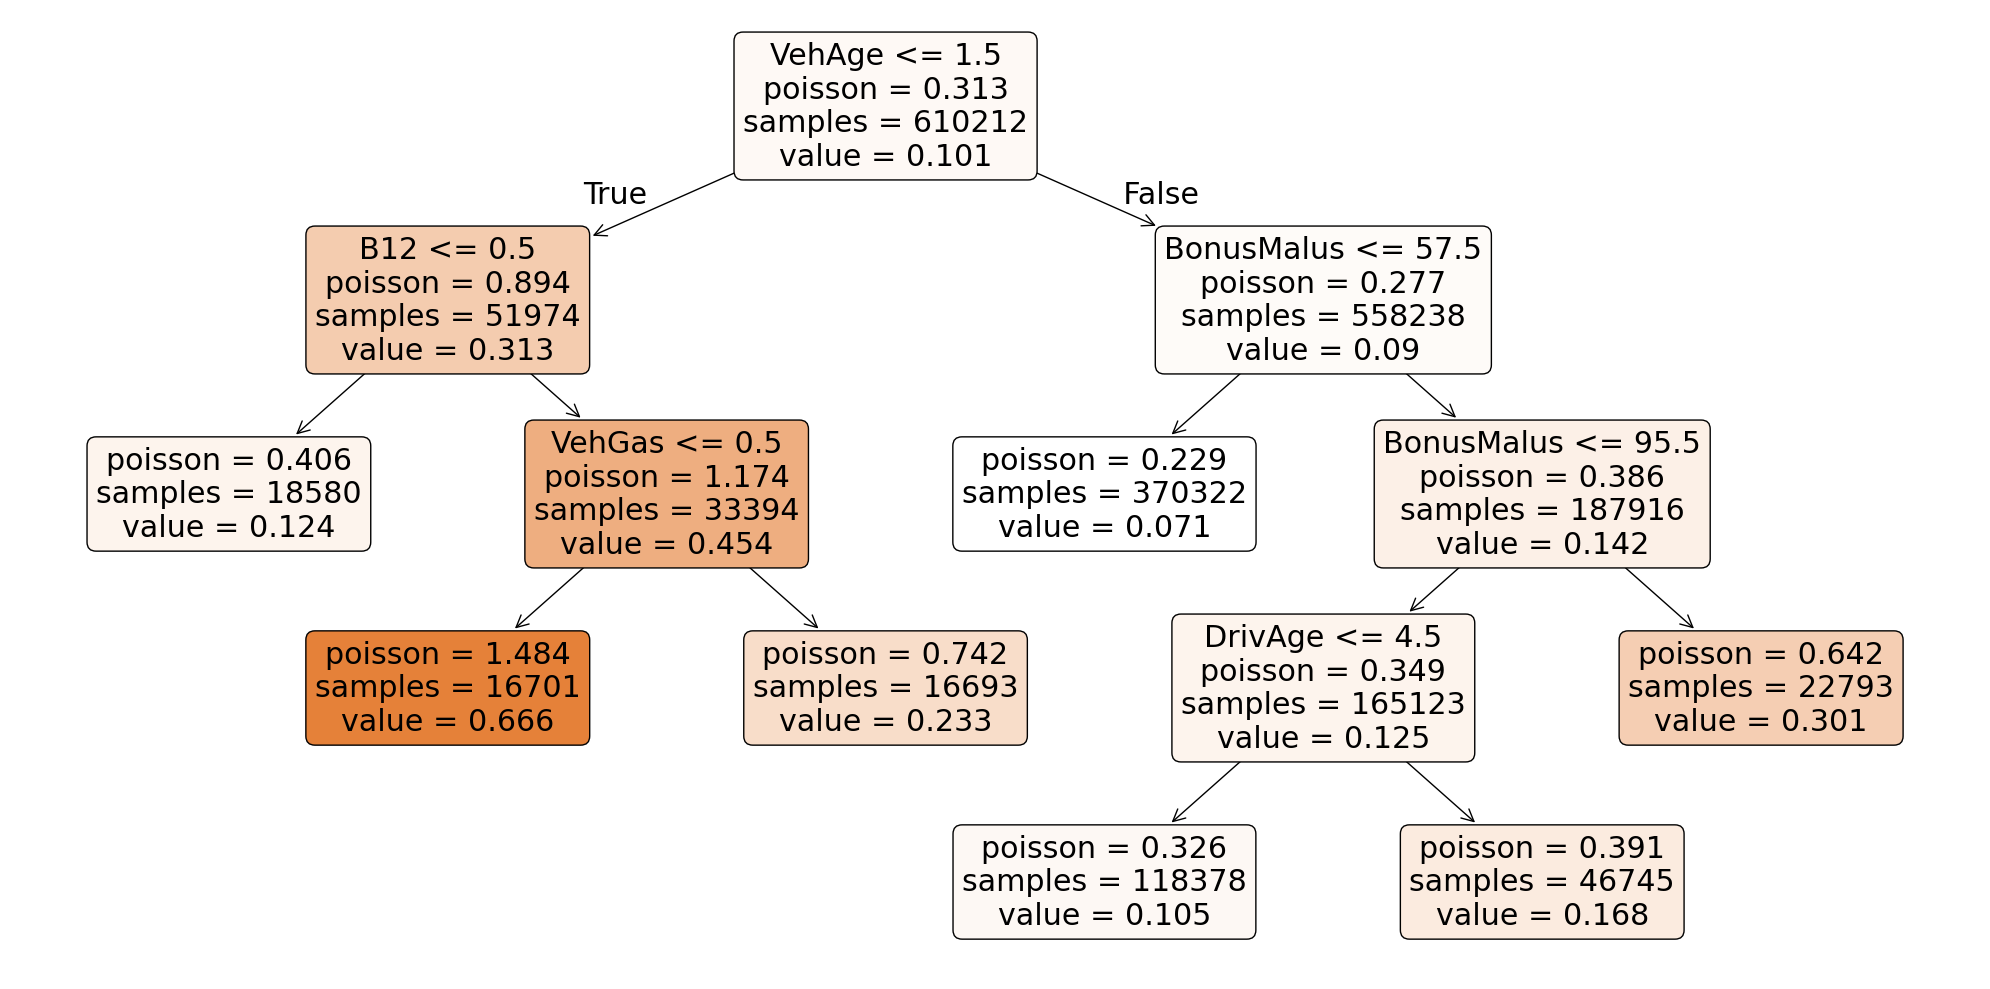

In [14]:
tree = DecisionTreeRegressor(
    criterion="poisson",
    min_samples_leaf=10000,
    ccp_alpha=0.0005,
)
start = time.time()
tree.fit(X, y, sample_weight=train["Exposure"])
end = time.time()
tempo_tree1 = end - start
tree.get_depth()
tree.get_n_leaves()

# Plot dell'albero
plt.figure(figsize=(20, 10))
plot_tree(tree, feature_names=features, filled=True, rounded=True)
plt.show(block = True)


Performance Primo Albero

In [15]:
prediction_tree = tree.predict(X)
prediction_tree1 = tree.predict(X_test)

print(f"Somma dei Lmabda_v stimati (trainig set): {sum(prediction_tree * train['Exposure'])} ")
print(f"Numero Totale dei stinistri (trainig set): {sum(train['ClaimNb'])}")

mu_tree = prediction_tree * train["Exposure"]
mu_tree_test = prediction_tree1 * test["Exposure"]
print(f"---Frequenze Empiriche sul Training Set---")
print(f"Numero Claim Osservato 0: {np.mean(train['ClaimNb'].values == 0)}")
print(f"Numero Claim Osservato 1: {np.mean(train['ClaimNb'].values == 1)}")
print(f"Numero Claim Osservato 2: {np.mean(train['ClaimNb'].values == 2)}")
print(f"Numero Claim Osservato 3: {np.mean(train['ClaimNb'].values == 3)}")
print(f"Numero Claim Osservato >=4: {np.mean(train['ClaimNb'].values >= 4)}")

print(f"---Frequenze Previste da modello 3 sul Training Set---")
print(f"Numero Claim Osservato 0: {np.mean(np.exp(-mu_tree.values))}")
print(f"Numero Claim Osservato 1: {np.mean(np.exp(-mu_tree.values) * mu_tree.values)}")
print(f"Numero Claim Osservato 2: {np.mean(np.exp(-mu_tree.values) * mu_tree.values**2 /2)}")
print(f"Numero Claim Osservato 3: {np.mean(np.exp(-mu_tree.values) * mu_tree.values**3 /6)}")
print(f"Numero Claim Osservato >=4: {np.mean(1 - np.exp(-mu_tree.values) - np.exp(-mu_tree.values) * mu_tree.values - np.exp(-mu_tree.values) * mu_tree.values**2 /2 - np.exp(-mu_tree.values) * mu_tree.values**3 /6 )}")

print(f"---Frequenze Empiriche sul Test Set---")
print(f"Numero Claim Osservato 0: {np.mean(test['ClaimNb'].values == 0)}")
print(f"Numero Claim Osservato 1: {np.mean(test['ClaimNb'].values == 1)}")
print(f"Numero Claim Osservato 2: {np.mean(test['ClaimNb'].values == 2)}")
print(f"Numero Claim Osservato 3: {np.mean(test['ClaimNb'].values == 3)}")
print(f"Numero Claim Osservato >=4: {np.mean(test['ClaimNb'].values >= 4)}")

print(f"---Frequenze Previste da modello 3 sul Test Set---")
print(f"Numero Claim Osservato 0: {np.mean(np.exp(-mu_tree_test.values))}")
print(f"Numero Claim Osservato 1: {np.mean(np.exp(-mu_tree_test.values) * mu_tree_test.values)}")
print(f"Numero Claim Osservato 2: {np.mean(np.exp(-mu_tree_test.values) * mu_tree_test.values**2 /2)}")
print(f"Numero Claim Osservato 3: {np.mean(np.exp(-mu_tree_test.values) * mu_tree_test.values**3 /6)}")
print(f"Numero Claim Osservato >=4: {np.mean(1 - np.exp(-mu_tree_test.values) - np.exp(-mu_tree_test.values) * mu_tree_test.values - np.exp(-mu_tree_test.values) * mu_tree_test.values**2 /2 - np.exp(-mu_tree_test.values) * mu_tree_test.values**3 /6 )}")



loss_tree = mean_poisson_deviance(train["ClaimNb"].values,mu_tree.values )
oos_loss_tree = mean_poisson_deviance(test["ClaimNb"].values,mu_tree_test.values )
print(f"Poisson deviance loss:{ loss_tree}")
print(f"Oos poisson deviance loss:{ oos_loss_tree}")


Somma dei Lmabda_v stimati (trainig set): 32489.000000164124 
Numero Totale dei stinistri (trainig set): 32489
---Frequenze Empiriche sul Training Set---
Numero Claim Osservato 0: 0.9497994139741598
Numero Claim Osservato 1: 0.04739500370363087
Numero Claim Osservato 2: 0.002656453822605914
Numero Claim Osservato 3: 0.0001261856535105832
Numero Claim Osservato >=4: 2.294284609283331e-05
---Frequenze Previste da modello 3 sul Training Set---
Numero Claim Osservato 0: 0.9494049089050393
Numero Claim Osservato 1: 0.048113844564626515
Numero Claim Osservato 2: 0.0023285649909562615
Numero Claim Osservato 3: 0.00014065019691321789
Numero Claim Osservato >=4: 1.2031342464590292e-05
---Frequenze Empiriche sul Test Set---
Numero Claim Osservato 0: 0.9494550227872746
Numero Claim Osservato 1: 0.048037639562838304
Numero Claim Osservato 2: 0.002404094334891816
Numero Claim Osservato 3: 7.374522499668146e-05
Numero Claim Osservato >=4: 2.9498089998672585e-05
---Frequenze Previste da modello 3 sul

Applicazione della 10-fold Cross Validation per determinare il Cost Complexity Parameter (ccp) ottimale.

In [16]:
#Step 1: creazione dei 10 fold
random.seed(100)
valori = np.array(X.index)
kfold = 10
size = round(len(valori)/10)
blocchi_X = []
blocchi_y =[]
blocchi_exposure = []
for i in range(kfold-1):
    indici = np.random.choice(valori,size=size, replace=False)
    blocchi_X.append(X.loc[indici,:])
    blocchi_y.append(y.loc[indici])
    blocchi_exposure.append(train.loc[indici,"Exposure"])
    valori = np.setdiff1d(valori,indici)
blocchi_X.append(X.loc[indici,:])
blocchi_y.append(y.loc[indici])
blocchi_exposure.append(train.loc[indici,"Exposure"])


In [17]:
#Step 2: costruzione dell'albero più grosso
ccp = 10**(-5) #ccp massimo fissato

tree2 = DecisionTreeRegressor(
    criterion="poisson",
    min_samples_leaf=10000,
    ccp_alpha=ccp,
)
start = time.time()
tree2.fit(X, y, sample_weight=train["Exposure"])
end = time.time()
tempo_tree2 = end - start
print(f"Numero Split:{tree2.get_depth()}")
print(f"Numero Foglie Terminali: {tree2.get_n_leaves()}")

prediction_tree2 = tree2.predict(X)
prediction_tree_test2 = tree2.predict(X_test)

mu_tree2 = prediction_tree2 * train["Exposure"]
mu_tree_test2 = prediction_tree_test2 * test["Exposure"]
loss_tree2 = mean_poisson_deviance(train["ClaimNb"].values,mu_tree2.values )
oos_loss_tree2 = mean_poisson_deviance(test["ClaimNb"].values,mu_tree_test2.values )
print(f"Poisson deviance loss:{ loss_tree2}")
print(f"Oos poisson deviance loss:{ oos_loss_tree2}")


Numero Split:11
Numero Foglie Terminali: 35
Poisson deviance loss:0.3089500634741673
Oos poisson deviance loss:0.31362208897604277


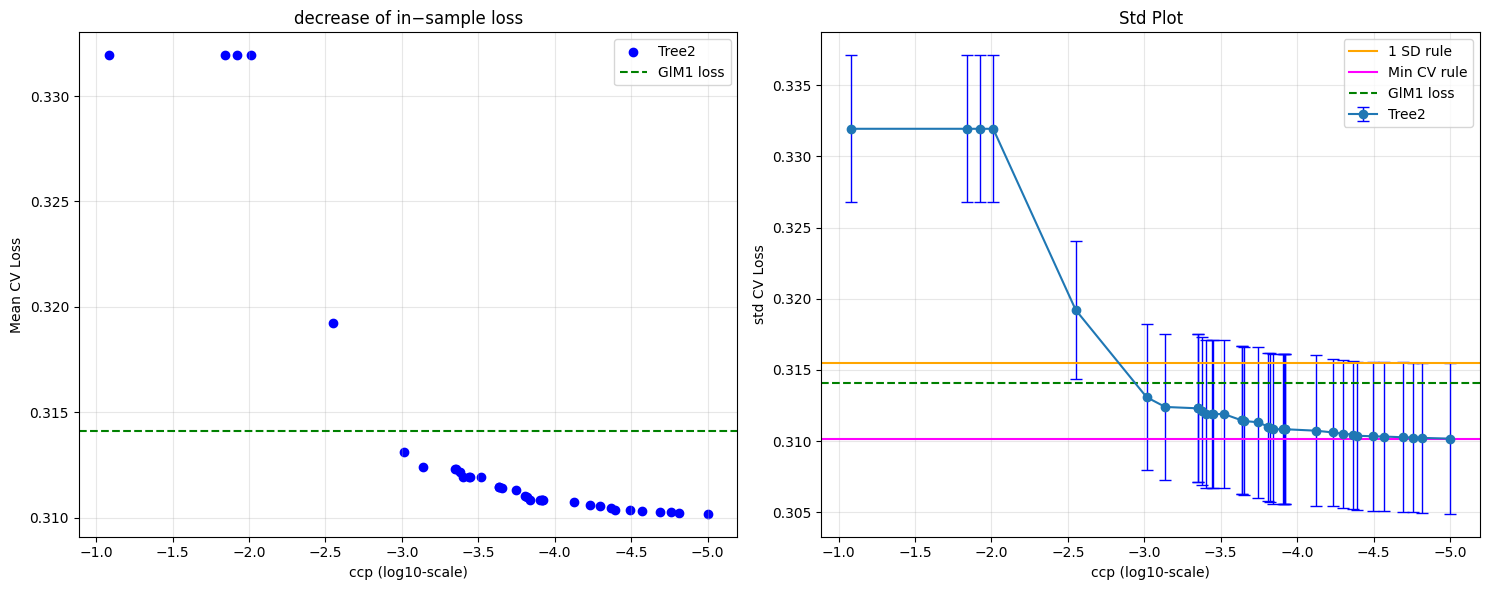

In [18]:
#Step 3: isolo il ccp path e fitto un albero per ogni valore del ccp
ccp_path = tree2.cost_complexity_pruning_path(X, y)["ccp_alphas"]
#tengo solo quelli che stanno sotto al ccp che ho fissato io
ccp_path = ccp_path[ccp_path>=ccp]
ccp_path = np.flipud(ccp_path)
ccp_path = np.append(ccp_path, ccp)
fold = np.arange(kfold)
mean_cv_loss = []
std_cv_loss = []
for alpha in ccp_path:
    cv_loss = []
    for i in range(kfold):
        fold_k = np.delete(fold,i)
        Xk = pd.concat([blocchi_X[j] for j in fold_k], axis=0)
        yk = pd.concat([blocchi_y[j] for j in fold_k], axis=0)
        exposurek = pd.concat([blocchi_exposure[j] for j in fold_k], axis=0)
        Xval = blocchi_X[i]
        yval = blocchi_y[i]
        exposureval = blocchi_exposure[i]
        treeCV = DecisionTreeRegressor(
            criterion="poisson",
            min_samples_leaf=10000,
            ccp_alpha=alpha,
        )
        treeCV.fit(Xk, yk, sample_weight=exposurek)
        predizioni = treeCV.predict(Xval)
        mu_tree_cv = predizioni * exposureval
        val_lossk = mean_poisson_deviance(yval.values * exposureval.values, mu_tree_cv.values)
        cv_loss.append(val_lossk)
    mean_cv_loss.append(np.mean(np.array(cv_loss)))
    std_cv_loss.append(np.std(np.array(cv_loss), ddof = 1))

fig,ax = plt.subplots(nrows=1, ncols=2)
ax[0].scatter(np.log10(ccp_path), mean_cv_loss, marker="o", color = "blue",label="Tree2")
ax[0].axhline(loss1,xmin=0,xmax=1,  linestyle = "--", color = "green", label = "GlM1 loss")
ax[0].grid(alpha=.3)
ax[0].invert_xaxis()
ax[0].set_xlabel("ccp (log10-scale)")
ax[0].set_ylabel("Mean CV Loss")
ax[0].set_title("decrease of in−sample loss")
ax[0].legend()

ax[1].errorbar(
    np.log10(ccp_path), mean_cv_loss, yerr=std_cv_loss,
    fmt='o-',
    ecolor='blue',
    elinewidth=1, capsize=4,
    capthick=1,
    label = "Tree2"
)
ax[1].axhline(mean_cv_loss[-1] + std_cv_loss[-1],xmin=0,xmax=1, color = "orange", label = "1 SD rule")
ax[1].axhline(mean_cv_loss[-1],xmin=0,xmax=1, color = "magenta", label = "Min CV rule")
ax[1].axhline(loss1,xmin=0,xmax=1,  linestyle = "--", color = "green", label = "GlM1 loss")
ax[1].invert_xaxis()
ax[1].set_xlabel("ccp (log10-scale)")
ax[1].set_ylabel("std CV Loss")
ax[1].set_title("Std Plot")
ax[1].grid(alpha=.3)
ax[1].legend()

plt.show(block=True)


In [19]:
#Step 4: isolo i risultati del tree della regression 1-SD rule (ossia il primo
#albero ad avere una CV validation loss media compresa in una standard deviation
#dall'albero a CV validation loss minima)
pos = ( np.array(mean_cv_loss)) <=(std_cv_loss[-1] + mean_cv_loss[-1])
ccp_1SDrule = ccp_path[pos][0]

tree3 = DecisionTreeRegressor(
    criterion="poisson",
    min_samples_leaf=10000,
    ccp_alpha=ccp_1SDrule,
)
start = time.time()
tree3.fit(X, y, sample_weight=train["Exposure"])
end = time.time()
tempo_tree3 = end - start
print(f"Numero Split:{tree3.get_depth()}")
print(f"Numero Foglie Terminali: {tree3.get_n_leaves()}")

prediction_tree3 = tree3.predict(X)
prediction_tree_test3 = tree3.predict(X_test)

mu_tree3 = prediction_tree3 * train["Exposure"]
mu_tree_test3 = prediction_tree_test3 * test["Exposure"]
loss_tree3 = mean_poisson_deviance(train["ClaimNb"].values,mu_tree3.values )
oos_loss_tree3 = mean_poisson_deviance(test["ClaimNb"].values,mu_tree_test3.values )
print(f"Poisson deviance loss:{ loss_tree3}")
print(f"Poisson deviance loss:{ oos_loss_tree3}")


Numero Split:3
Numero Foglie Terminali: 6
Poisson deviance loss:0.31212164681191495
Poisson deviance loss:0.3159085511915863


Confronto Alberi

In [20]:
tab_conf_tree = pd.concat([pd.DataFrame(np.array([tempo_tree1,tempo_tree2,tempo_tree3])),
                           pd.DataFrame(np.array([tree.get_n_leaves(), tree2.get_n_leaves(), tree3.get_n_leaves()])),
                           pd.DataFrame(np.array([loss_tree,loss_tree2,loss_tree3])),
                           pd.DataFrame(np.array([oos_loss_tree, oos_loss_tree2, oos_loss_tree3]))],axis = 1)

tab_conf_tree.columns = ["run time","N param","In-sample loss","out-of-sample loss"]
tab_conf_tree.index = ["Tree 1 (alpha = 0.0005)","Tree 2 (alpha = 0,0001)",f"Tree 3 (alpha = {ccp_1SDrule:2f})"]
with pd.option_context(
    "display.max_rows", None,
    "display.max_columns", None,
    "display.width", None,
    "display.max_colwidth", None
):
    print(tab_conf_tree)


                           run time  N param  In-sample loss  \
Tree 1 (alpha = 0.0005)    2.665197        7        0.311337   
Tree 2 (alpha = 0,0001)    2.561733       35        0.308950   
Tree 3 (alpha = 0.000966)  2.543253        6        0.312122   

                           out-of-sample loss  
Tree 1 (alpha = 0.0005)              0.315352  
Tree 2 (alpha = 0,0001)              0.313622  
Tree 3 (alpha = 0.000966)            0.315909  


Ripeto la CV con una sample size minima per foglia di 1000.
Il fatto di fissare a 10000il numero di componenti minimi per foglia gestisce già parzialmente il problema dell'overftitting.
La CV potrebbe anche non servire, l'albero più grosso funziona meglio anche out of sample.

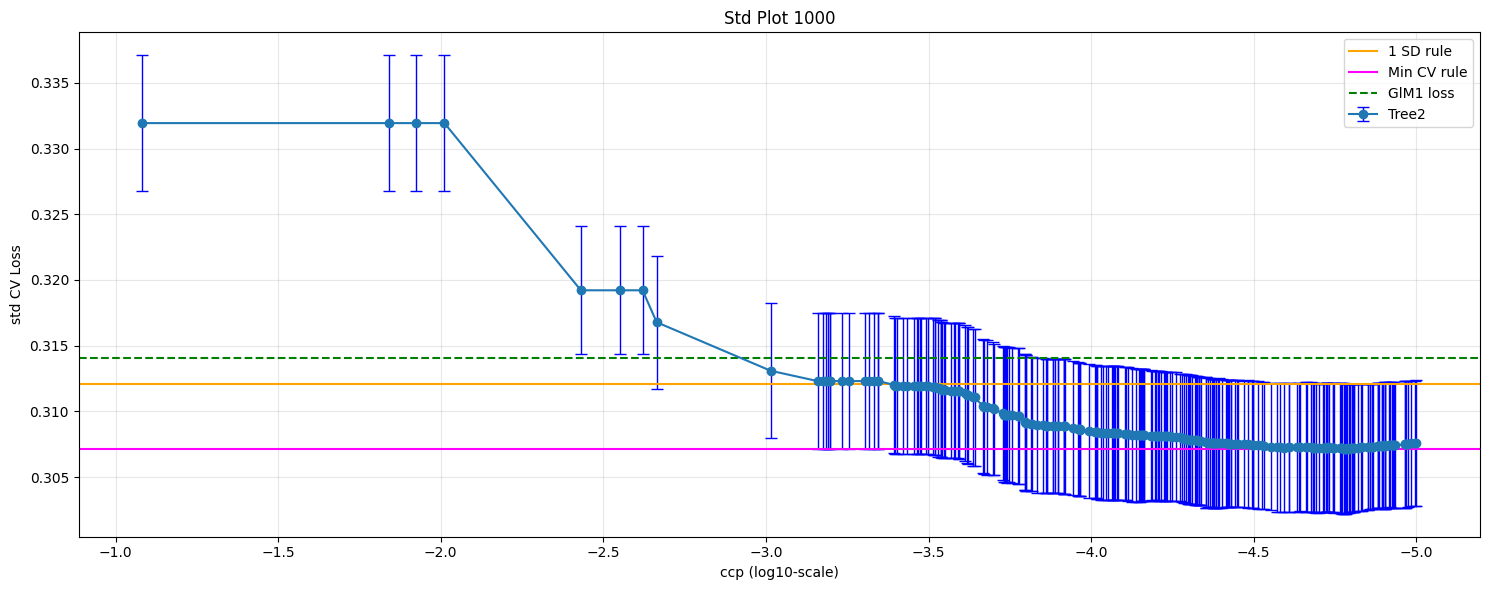

In [21]:
tree_final = DecisionTreeRegressor(
    criterion="poisson",
    min_samples_leaf=1000,
    ccp_alpha=ccp,
)
tree_final.fit(X, y, sample_weight=train["Exposure"])
ccp_path1000 = tree_final.cost_complexity_pruning_path(X, y)["ccp_alphas"]
#tengo solo quelli che stanno sotto al ccp che ho fissato io
ccp_path1000 = ccp_path1000[ccp_path1000>=ccp]
ccp_path1000 = np.flipud(ccp_path1000)
ccp_path1000 = np.append(ccp_path1000, ccp)

mean_cv_loss1000 = []
std_cv_loss1000 = []
for alpha in ccp_path1000:
    cv_loss = []
    for i in range(kfold):
        fold_k = np.delete(fold,i)
        Xk = pd.concat([blocchi_X[j] for j in fold_k], axis=0)
        yk = pd.concat([blocchi_y[j] for j in fold_k], axis=0)
        exposurek = pd.concat([blocchi_exposure[j] for j in fold_k], axis=0)
        Xval = blocchi_X[i]
        yval = blocchi_y[i]
        exposureval = blocchi_exposure[i]
        treeCV = DecisionTreeRegressor(
            criterion="poisson",
            min_samples_leaf=1000,
            ccp_alpha=alpha,
        )
        treeCV.fit(Xk, yk, sample_weight=exposurek)
        predizioni = treeCV.predict(Xval)
        mu_tree_cv = predizioni * exposureval
        val_lossk = mean_poisson_deviance(yval.values * exposureval.values, mu_tree_cv.values)
        cv_loss.append(val_lossk)
    mean_cv_loss1000.append(np.mean(np.array(cv_loss)))
    std_cv_loss1000.append(np.std(np.array(cv_loss), ddof = 1))

mean_cv_loss1000 =np.array(mean_cv_loss1000)
std_cv_loss1000 = np.array(std_cv_loss1000)

fig,ax = plt.subplots()
ax.errorbar(
    np.log10(ccp_path1000), mean_cv_loss1000, yerr=std_cv_loss1000,
    fmt='o-',
    ecolor='blue',
    elinewidth=1, capsize=4,
    capthick=1,
    label = "Tree2"
)
ax.axhline(np.min(mean_cv_loss1000) + std_cv_loss1000[mean_cv_loss1000 ==np.min(mean_cv_loss1000)],xmin=0,xmax=1, color = "orange", label = "1 SD rule")
ax.axhline(np.min(mean_cv_loss1000),xmin=0,xmax=1, color = "magenta", label = "Min CV rule")
ax.axhline(loss1,xmin=0,xmax=1,  linestyle = "--", color = "green", label = "GlM1 loss")
ax.invert_xaxis()
ax.set_xlabel("ccp (log10-scale)")
ax.set_ylabel("std CV Loss")
ax.set_title("Std Plot 1000")
ax.grid(alpha=.3)
ax.legend()

plt.show(block=True)


In [22]:
#estrazione dell'albero con CV loss minima
ccp_minimo = ccp_path1000[mean_cv_loss1000 == np.min(mean_cv_loss1000)][0]
tree1000 = DecisionTreeRegressor(
    criterion="poisson",
    min_samples_leaf=1000,
    ccp_alpha=ccp_minimo,
)
start = time.time()
tree1000.fit(X, y, sample_weight=train["Exposure"])
end = time.time()
tempo_tree1000 = end - start
print(f"Numero Split:{tree1000.get_depth()}")
print(f"Numero Foglie Terminali: {tree1000.get_n_leaves()}")

prediction_tree1000 = tree1000.predict(X)
prediction_tree_test1000 = tree1000.predict(X_test)

mu_tree1000 = prediction_tree1000 * train["Exposure"]
mu_tree_test1000 = prediction_tree_test1000 * test["Exposure"]
loss_tree1000 = mean_poisson_deviance(train["ClaimNb"].values,mu_tree1000.values )
oos_loss_tree1000 = mean_poisson_deviance(test["ClaimNb"].values,mu_tree_test1000.values )
print(f"Poisson deviance loss:{ loss_tree1000}")
print(f"Poisson deviance loss:{ oos_loss_tree1000}")

tabella_conf_tree1000 = pd.concat([pd.DataFrame(np.array([tempo_tree1000,tempo_mod1])),
                                   pd.DataFrame(np.array([tree1000.get_n_leaves(),len(model1.params.values)])),
                                   pd.DataFrame(np.array([loss_tree1000,loss1])),
                                   pd.DataFrame(np.array([oos_loss_tree1000, oos_loss1]))
                                   ],axis = 1)
tabella_conf_tree1000.columns = ["run time", "n param", "in-sample loss", "out-of-sample loss"]
tabella_conf_tree1000.index = ["Tree 1000", "GLM1"]
print(tabella_conf_tree1000)


Numero Split:13
Numero Foglie Terminali: 87
Poisson deviance loss:0.30508018628000483
Poisson deviance loss:0.3103726962231465
            run time  n param  in-sample loss  out-of-sample loss
Tree 1000   3.998971       87        0.305080            0.310373
GLM1       15.144727       49        0.314087            0.317888


Applicazione delle Boosting Machines ad una poisson (PBM)

In [23]:
#applicazione di boosting con tree con J=1 profondità massima degli alberi, itero 30 stimatori

J = 1 #profondità massima dell'albero
M = 30 #numero di iterazioni di boosting
X_boosting = X
y_boosting = train["ClaimNb"]/train["Exposure"]
exposure_boosting = train["Exposure"]
exposure_boosting_test = test["Exposure"]
loss_path1 = []
start = time.time()
for i in range(M):
    #si fitta l'abero sul training set
    tree_boosting = DecisionTreeRegressor( criterion="poisson", min_samples_leaf= 10000,ccp_alpha=0.00001,
                                           max_depth = J)
    tree_boosting.fit(X_boosting, y_boosting, sample_weight= exposure_boosting)
    #si calcolano le previsioni sul train e sul test set
    previsioni = tree_boosting.predict(X_boosting)
    previsioni_test = tree_boosting.predict(X_test)

    #si aggiustano le exposure per il passo successivo
    exposure_boosting = previsioni * exposure_boosting
    exposure_boosting_test = previsioni_test * exposure_boosting_test
    loss_path1.append(mean_poisson_deviance(train["ClaimNb"].values,exposure_boosting.values))
    #Si calocolano regresssori fratto "nuovo v" aggiornato
    y_boosting = train["ClaimNb"]/exposure_boosting

predizioni_finali1_train = exposure_boosting
predizioni_finali1_test = exposure_boosting_test
end = time.time()
tempo_boost1 = end - start

loss_boost1 = mean_poisson_deviance(train["ClaimNb"].values,exposure_boosting.values)
loss_boost1_test = mean_poisson_deviance(test["ClaimNb"].values,predizioni_finali1_test.values)

print(f"Somma dei Lmabda_v stimati (trainig set): {sum(predizioni_finali1_train)} ")
print(f"Numero Totale dei stinistri (trainig set): {sum(train['ClaimNb'])}")


print(f"---Frequenze Empiriche sul Training Set---")
print(f"Numero Claim Osservato 0: {np.mean(train['ClaimNb'].values == 0)}")
print(f"Numero Claim Osservato 1: {np.mean(train['ClaimNb'].values == 1)}")
print(f"Numero Claim Osservato 2: {np.mean(train['ClaimNb'].values == 2)}")
print(f"Numero Claim Osservato 3: {np.mean(train['ClaimNb'].values == 3)}")
print(f"Numero Claim Osservato >=4: {np.mean(train['ClaimNb'].values >= 4)}")

print(f"---Frequenze Previste da modello 3 sul Training Set---")
print(f"Numero Claim Osservato 0: {np.mean(np.exp(-predizioni_finali1_train.values))}")
print(f"Numero Claim Osservato 1: {np.mean(np.exp(-predizioni_finali1_train.values) * predizioni_finali1_train.values)}")
print(f"Numero Claim Osservato 2: {np.mean(np.exp(-predizioni_finali1_train.values) * predizioni_finali1_train.values**2 /2)}")
print(f"Numero Claim Osservato 3: {np.mean(np.exp(-predizioni_finali1_train.values) * predizioni_finali1_train.values**3 /6)}")
print(f"Numero Claim Osservato >=4: {np.mean(1 - np.exp(-predizioni_finali1_train.values) - np.exp(-predizioni_finali1_train.values) * predizioni_finali1_train.values - np.exp(-predizioni_finali1_train.values) * predizioni_finali1_train.values**2 /2 - np.exp(-predizioni_finali1_train.values) * predizioni_finali1_train.values**3 /6 )}")

print(f"---Frequenze Empiriche sul Test Set---")
print(f"Numero Claim Osservato 0: {np.mean(test['ClaimNb'].values == 0)}")
print(f"Numero Claim Osservato 1: {np.mean(test['ClaimNb'].values == 1)}")
print(f"Numero Claim Osservato 2: {np.mean(test['ClaimNb'].values == 2)}")
print(f"Numero Claim Osservato 3: {np.mean(test['ClaimNb'].values == 3)}")
print(f"Numero Claim Osservato >=4: {np.mean(test['ClaimNb'].values >= 4)}")

print(f"---Frequenze Previste da modello 3 sul Test Set---")
print(f"Numero Claim Osservato 0: {np.mean(np.exp(-predizioni_finali1_test.values))}")
print(f"Numero Claim Osservato 1: {np.mean(np.exp(-predizioni_finali1_test.values) * predizioni_finali1_test.values)}")
print(f"Numero Claim Osservato 2: {np.mean(np.exp(-predizioni_finali1_test.values) * predizioni_finali1_test.values**2 /2)}")
print(f"Numero Claim Osservato 3: {np.mean(np.exp(-predizioni_finali1_test.values) * predizioni_finali1_test.values**3 /6)}")
print(f"Numero Claim Osservato >=4: {np.mean(1 - np.exp(-predizioni_finali1_test.values) - np.exp(-predizioni_finali1_test.values) * predizioni_finali1_test.values - np.exp(-predizioni_finali1_test.values) * predizioni_finali1_test.values**2 /2 - np.exp(-predizioni_finali1_test.values) * predizioni_finali1_test.values**3 /6 )}")




Somma dei Lmabda_v stimati (trainig set): 32489.00000001296 
Numero Totale dei stinistri (trainig set): 32489
---Frequenze Empiriche sul Training Set---
Numero Claim Osservato 0: 0.9497994139741598
Numero Claim Osservato 1: 0.04739500370363087
Numero Claim Osservato 2: 0.002656453822605914
Numero Claim Osservato 3: 0.0001261856535105832
Numero Claim Osservato >=4: 2.294284609283331e-05
---Frequenze Previste da modello 3 sul Training Set---
Numero Claim Osservato 0: 0.9492699769045686
Numero Claim Osservato 1: 0.04835575016292308
Numero Claim Osservato 2: 0.002246777460556322
Numero Claim Osservato 3: 0.0001181451881241377
Numero Claim Osservato >=4: 9.350283827917492e-06
---Frequenze Empiriche sul Test Set---
Numero Claim Osservato 0: 0.9494550227872746
Numero Claim Osservato 1: 0.048037639562838304
Numero Claim Osservato 2: 0.002404094334891816
Numero Claim Osservato 3: 7.374522499668146e-05
Numero Claim Osservato >=4: 2.9498089998672585e-05
---Frequenze Previste da modello 3 sul Test

Poisson Boosting Machine con J = 2 (Profondità massima alberi di boosting) e M = 50 (Numero stimatori iterati)

In [24]:
#applicazione di boosting con tree con J=2 profondità massima degli alberi, itero 50 stimatori
J = 2 #profondità massima dell'albero
M = 50 #numero di iterazioni di boosting
y_boosting = train["ClaimNb"]/train["Exposure"]
exposure_boosting = train["Exposure"]
exposure_boosting_test = test["Exposure"]
loss_path2 = []
start = time.time()
for i in range(M):
    #si fitta l'abero sul training set
    tree_boosting = DecisionTreeRegressor( criterion="poisson", min_samples_leaf= 10000,ccp_alpha=0.00001,
                                           max_depth = J)
    tree_boosting.fit(X_boosting, y_boosting, sample_weight= exposure_boosting)
    #si calcolano le previsioni sul train e sul test set
    previsioni = tree_boosting.predict(X_boosting)
    previsioni_test = tree_boosting.predict(X_test)
    #si aggiustano le exposure per il passo successivo
    exposure_boosting = previsioni * exposure_boosting
    exposure_boosting_test = previsioni_test * exposure_boosting_test
    loss_path2.append(mean_poisson_deviance(train["ClaimNb"].values, exposure_boosting.values))

    #Si calocolano regresssori fratto "nuovo v" aggiornato
    y_boosting = train["ClaimNb"]/exposure_boosting

predizioni_finali2_train = exposure_boosting
predizioni_finali2_test = exposure_boosting_test
end = time.time()
tempo_boost2 = end - start
print(f"Somma dei Lmabda_v stimati (trainig set): {sum(predizioni_finali2_train)} ")
print(f"Numero Totale dei stinistri (trainig set): {sum(train['ClaimNb'])}")

loss_boost2 = mean_poisson_deviance(train["ClaimNb"].values,predizioni_finali2_train.values)
loss_boost2_test = mean_poisson_deviance(test["ClaimNb"].values,predizioni_finali2_test.values)


Somma dei Lmabda_v stimati (trainig set): 32488.99999999906 
Numero Totale dei stinistri (trainig set): 32489


Poisson Boosting Machine con J = 3 M = 50

In [25]:
#applicazione di boosting con tree con J=3 profondità massima degli alberi, itero 50 stimatori
J = 3 #profondità massima dell'albero
M = 50 #numero di iterazioni di boosting
y_boosting = train["ClaimNb"]/train["Exposure"]
exposure_boosting = train["Exposure"]
exposure_boosting_test = test["Exposure"]
loss_path3 = []
start = time.time()
for i in range(M):
    #si fitta l'abero sul training set
    tree_boosting = DecisionTreeRegressor( criterion="poisson", min_samples_leaf= 10000,ccp_alpha=0.00001,
                                           max_depth = J)
    tree_boosting.fit(X_boosting, y_boosting, sample_weight= exposure_boosting)
    #si calcolano le previsioni sul train e sul test set
    previsioni = tree_boosting.predict(X_boosting)
    previsioni_test = tree_boosting.predict(X_test)


    #si aggiustano le exposure per il passo successivo
    exposure_boosting = previsioni * exposure_boosting
    exposure_boosting_test = previsioni_test * exposure_boosting_test
    loss_path3.append(mean_poisson_deviance(train["ClaimNb"].values, exposure_boosting.values))

    #Si calocolano regresssori fratto "nuovo v" aggiornato
    y_boosting = train["ClaimNb"]/exposure_boosting

predizioni_finali3_train = exposure_boosting
predizioni_finali3_test = exposure_boosting_test
end = time.time()
tempo_boost3 = end - start
print(f"Somma dei Lmabda_v stimati (trainig set): {sum(predizioni_finali3_train)} ")
print(f"Numero Totale dei stinistri (trainig set): {sum(train['ClaimNb'])}")

loss_boost3 = mean_poisson_deviance(train["ClaimNb"].values,predizioni_finali3_train.values)
loss_boost3_test = mean_poisson_deviance(test["ClaimNb"].values,predizioni_finali3_test.values)


Somma dei Lmabda_v stimati (trainig set): 32489.00000000072 
Numero Totale dei stinistri (trainig set): 32489


Plot di confrinto sul training set

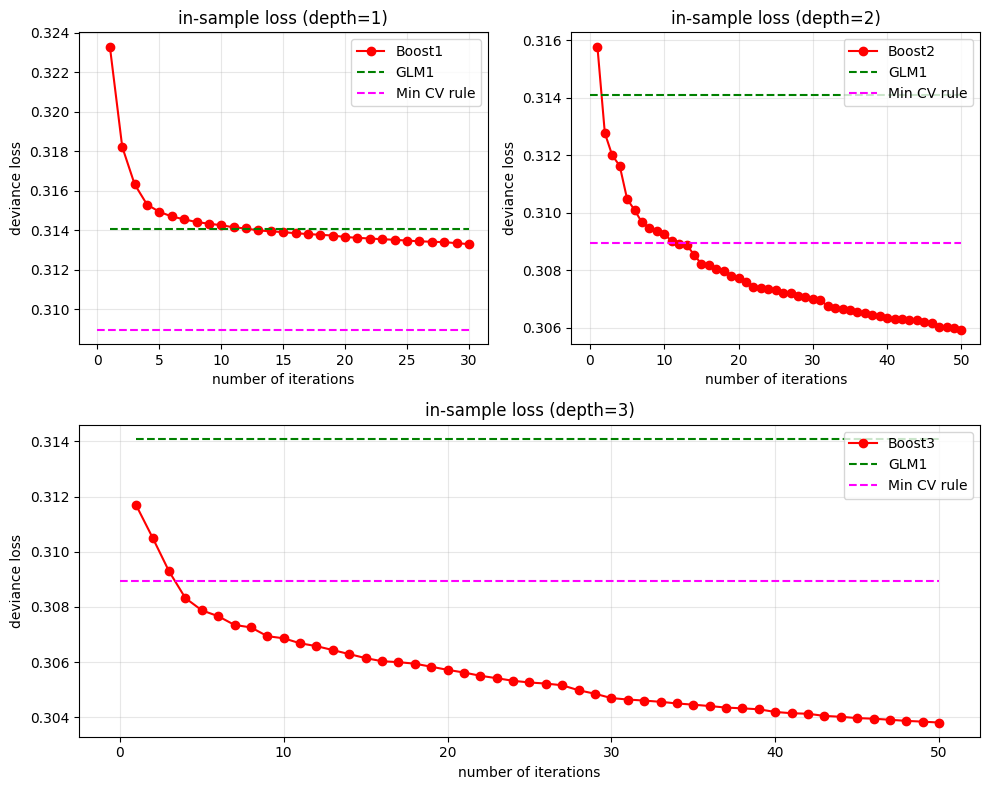

In [26]:
fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])

ax1.plot(np.arange(30)+1, loss_path1, linestyle = "-", marker = "o", markerfacecolor='red', color = "red", label = "Boost1")
ax1.hlines(loss1,xmin=1,xmax=30, color="green", linestyle ="--", label = "GLM1")
ax1.hlines(loss_tree2,xmin=0,xmax=30, linestyle ="--",color = "magenta", label = "Min CV rule")
ax1.set_xlabel("number of iterations")
ax1.set_ylabel("deviance loss")
ax1.set_title("in-sample loss (depth=1)")
ax1.grid(alpha=.3)
ax1.legend()

ax2.plot(np.arange(50)+1, loss_path2, linestyle = "-", marker = "o", markerfacecolor='red', color = "red", label = "Boost2")
ax2.hlines(loss1,xmin=0,xmax=50, color="green", linestyle ="--", label = "GLM1")
ax2.hlines(loss_tree2,xmin=0,xmax=50, linestyle ="--",color = "magenta", label = "Min CV rule")
ax2.set_xlabel("number of iterations")
ax2.set_ylabel("deviance loss")
ax2.set_title("in-sample loss (depth=2)")
ax2.grid(alpha=.3)
ax2.legend()

ax3.plot(np.arange(50)+1, loss_path3, linestyle = "-", marker = "o", markerfacecolor='red', color = "red", label = "Boost3")
ax3.hlines(loss1,xmin=1,xmax=50, color="green", linestyle ="--", label = "GLM1")
ax3.hlines(loss_tree2,xmin=0,xmax=50, linestyle ="--",color = "magenta", label = "Min CV rule")
ax3.set_xlabel("number of iterations")
ax3.set_ylabel("deviance loss")
ax3.set_title("in-sample loss (depth=3)")
ax3.grid(alpha=.3)
ax3.legend()

plt.tight_layout()
plt.show(block=True)


Boosting con aggiunta di shrinkage factor v = 0.75 questo fattore eleva i nuovi stimatori che vengono moltiplicati al fine di renderli ancora più weak

Somma dei Lmabda_v stimati (trainig set): 32485.505263833336 
Numero Totale dei stinistri (trainig set): 32489
in-sample poisson deviance loss:0.3040907486084059
out-of-sample poisson deviance loss:0.3040907486084059


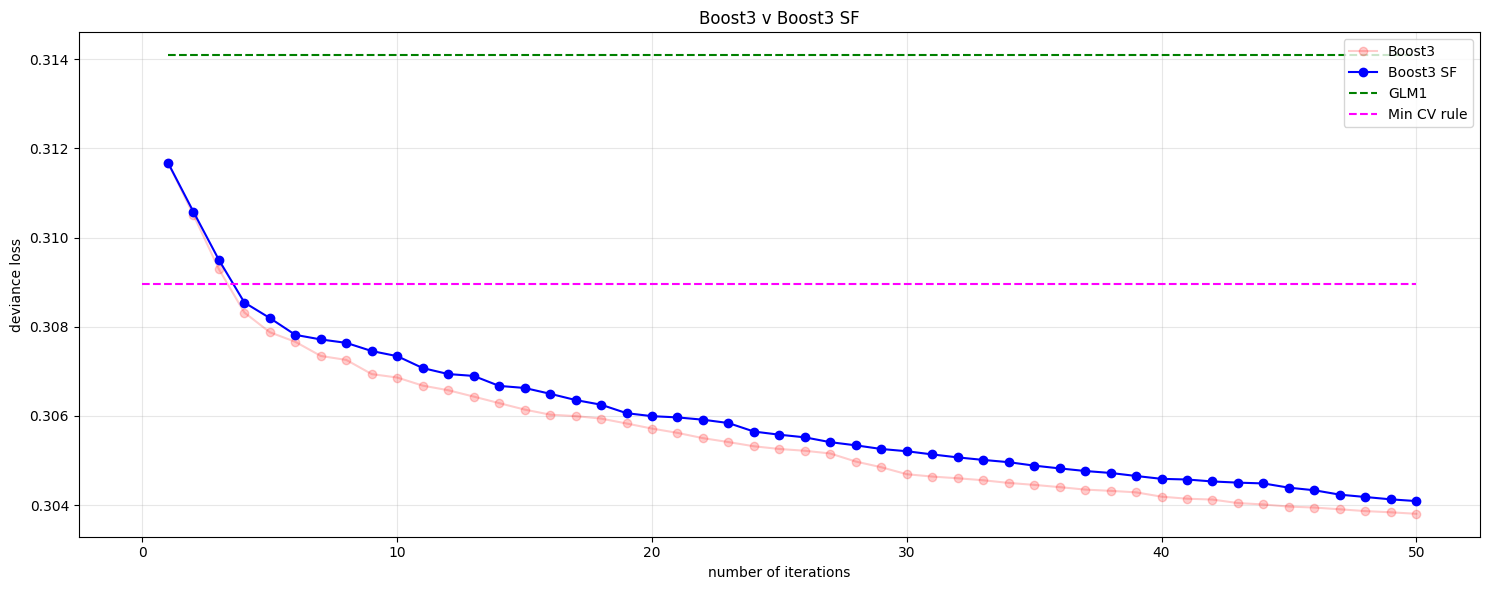

In [27]:
##test di boosting  con shrinkage v e con tree con J profondità massima degli alberi, itero 50 stimatori
J = 3 #profondità dell'albero
M = 50 #numero di iterazioni
v = 0.75 #shrinkage factor
X_boosting = X
X_boosting_test = X_test
y_boosting = train["ClaimNb"]/train["Exposure"]
exposure_boosting = train["Exposure"]
exposure_boosting_test = test["Exposure"]
loss_path_shrinkage = []
start = time.time()
for i in range(M):
    tree_boosting_shrink = DecisionTreeRegressor(criterion="poisson", min_samples_leaf=10000, ccp_alpha=0.00001,
                                                 max_depth=J)
    tree_boosting_shrink.fit(X_boosting, y_boosting, sample_weight=exposure_boosting)
    previsioni = tree_boosting_shrink.predict(X_boosting)
    previsioni_test = tree_boosting_shrink.predict(X_boosting_test)

    if i ==0:
        #Per la prima devo stimare un albero classico.
        exposure_boosting = previsioni  * exposure_boosting
        exposure_boosting_test = previsioni_test * exposure_boosting_test
    else:
        #Dalla seconda in poi applico gli aggiornamenti con lo shrinkage factor.
        exposure_boosting = previsioni**v * exposure_boosting
        exposure_boosting_test = previsioni_test**v * exposure_boosting_test
    loss_path_shrinkage.append(mean_poisson_deviance(train["ClaimNb"], exposure_boosting))
    y_boosting = train["ClaimNb"] / exposure_boosting

predizioni_finali_shrink = exposure_boosting
predizioni_finali_shrink_test = exposure_boosting_test
end = time.time()
tempo_srinkage = end - start
print(f"Somma dei Lmabda_v stimati (trainig set): {sum(predizioni_finali_shrink)} ")
print(f"Numero Totale dei stinistri (trainig set): {sum(train['ClaimNb'])}")


loss_shrink = mean_poisson_deviance(train["ClaimNb"], predizioni_finali_shrink)
print(f"in-sample poisson deviance loss:{loss_shrink}")
oos_loss_shrink = mean_poisson_deviance(train["ClaimNb"], predizioni_finali_shrink)
print(f"out-of-sample poisson deviance loss:{oos_loss_shrink}")

fig, ax = plt.subplots()
ax.plot(np.arange(50)+1, loss_path3, linestyle = "-", marker = "o", markerfacecolor='red', color = "red", label = "Boost3", alpha = 0.2)
ax.plot(np.arange(50)+1, loss_path_shrinkage, linestyle = "-", marker = "o", markerfacecolor="blue", color = "blue", label ="Boost3 SF")
ax.hlines(loss1,xmin=1,xmax=50, color="green", linestyle ="--", label = "GLM1")
ax.hlines(loss_tree2,xmin=0,xmax=50, linestyle ="--",color = "magenta", label = "Min CV rule")
ax.set_xlabel("number of iterations")
ax.set_ylabel("deviance loss")
ax.set_title("Boost3 v Boost3 SF")
ax.grid(alpha=.3)
ax.legend()
plt.show(block=True)


Procedura integrata PBM con shrinkage factor applicata ai resudui del modello GLM1

Tempo Impiegato: 66.75113606452942
in-sample poisson deviance loss:0.3038981794407619
out-of-sample poisson deviance loss:0.3038981794407619


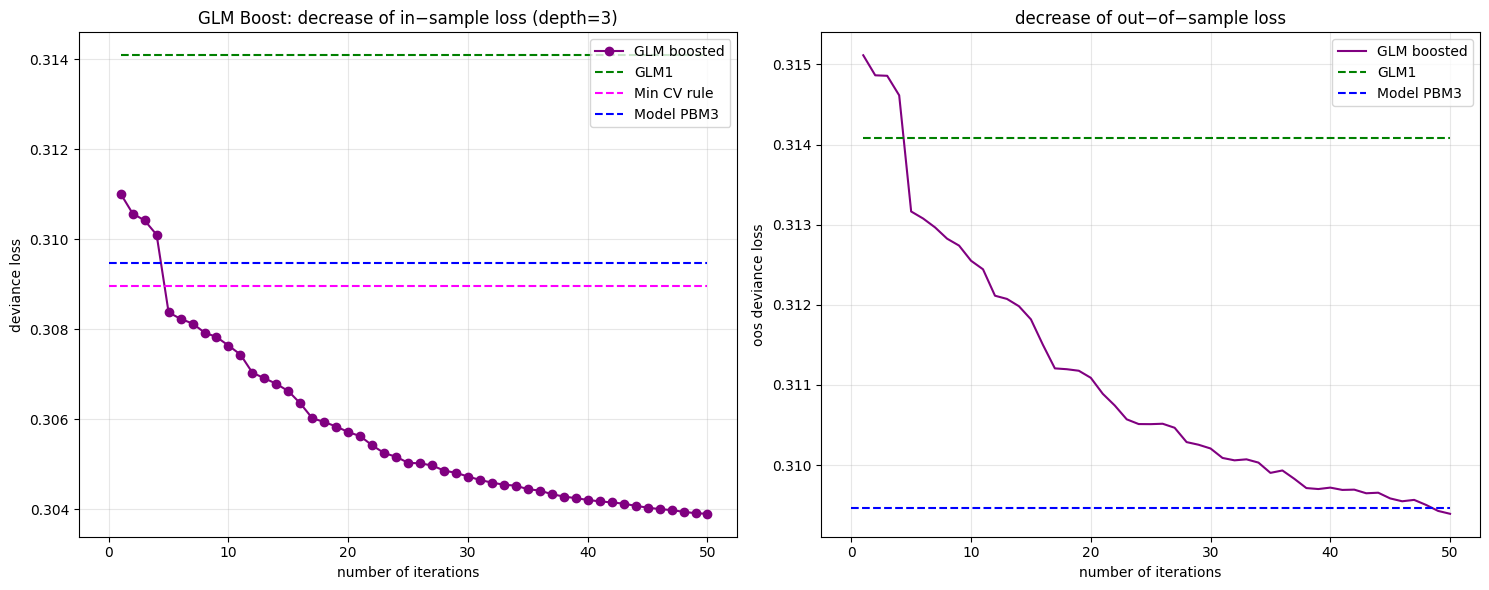

In [28]:
#-----------boosting con shirnkage applicato al GLM1 ----------------
J = 3 #profondità dell'albero
M = 50 #numero di iterazioni
v = 0.75 #shrinkage factor
X_boosting = X
X_boosting_test = X_test
exposure_boosting = model1.mu #estrazione stime del modello 1
exposure_boosting_test = prediction1
y_boosting = train["ClaimNb"]/exposure_boosting
loss_path_GLMboost = []
loss_path_GLMboost_test = []
start = time.time()
for i in range(M):
    tree_boosting_shrink_GLM = DecisionTreeRegressor(criterion="poisson", min_samples_leaf=10000, ccp_alpha=0.00001,
                                          max_depth=J)
    tree_boosting_shrink_GLM.fit(X_boosting, y_boosting, sample_weight=exposure_boosting)

    previsioni = tree_boosting_shrink_GLM.predict(X_boosting)
    previsioni_test = tree_boosting_shrink_GLM.predict(X_boosting_test)

    exposure_boosting = previsioni**v * exposure_boosting
    exposure_boosting_test = previsioni_test**v * exposure_boosting_test
    loss_path_GLMboost.append(mean_poisson_deviance(train["ClaimNb"].values, exposure_boosting) )
    loss_path_GLMboost_test.append(mean_poisson_deviance(test["ClaimNb"].values, exposure_boosting_test))

    y_boosting = train["ClaimNb"] / exposure_boosting
predizioni_finali_shrink_GLM = exposure_boosting
predizioni_finali_shrink_GLM_test = exposure_boosting_test
end =time.time()
tempo_boostGLM = end - start
print(f"Tempo Impiegato: {tempo_boostGLM}")

loss_GLMboost = mean_poisson_deviance(train["ClaimNb"], predizioni_finali_shrink_GLM)
print(f"in-sample poisson deviance loss:{loss_GLMboost}")
oos_loss_GLMboost = mean_poisson_deviance(test["ClaimNb"], predizioni_finali_shrink_GLM_test)
print(f"out-of-sample poisson deviance loss:{loss_GLMboost}")


fig, ax = plt.subplots(nrows=1, ncols = 2)
ax[0].plot(np.arange(50)+1, loss_path_GLMboost, linestyle = "-", marker = "o", markerfacecolor='purple', color = "purple", label = "GLM boosted")
ax[0].hlines(loss1,xmin=1,xmax=50, color="green", linestyle ="--", label = "GLM1")
ax[0].hlines(loss_tree2,xmin=0,xmax=50, linestyle ="--",color = "magenta", label = "Min CV rule")
ax[0].hlines(loss_boost3_test,xmin=0,xmax=50, linestyle ="--",color = "blue", label = "Model PBM3")
ax[0].set_xlabel("number of iterations")
ax[0].set_ylabel("deviance loss")
ax[0].set_title("GLM Boost: decrease of in−sample loss (depth=3)")
ax[0].grid(alpha=.3)
ax[0].legend()

ax[1].plot(np.arange(50)+1, loss_path_GLMboost_test, linestyle = "-", markerfacecolor='purple', color = "purple", label = "GLM boosted")
ax[1].hlines(loss1,xmin=1,xmax=50, color="green", linestyle ="--", label = "GLM1")
ax[1].hlines(loss_boost3_test,xmin=0,xmax=50, linestyle ="--",color = "blue", label = "Model PBM3")
ax[1].set_xlabel("number of iterations")
ax[1].set_ylabel("oos deviance loss")
ax[1].set_title("decrease of out−of−sample loss")
ax[1].grid(alpha=.3)
ax[1].legend()
plt.show(block=True)


Tabella di confronto dei diversi modelli

In [29]:
tab_conf_boost = pd.concat([pd.DataFrame(np.array([loss_GLMboost,loss_boost3, loss_tree2,loss_tree1000,loss1])),
                            pd.DataFrame(np.array([oos_loss_GLMboost,loss_boost3_test, oos_loss_tree2,oos_loss_tree1000,oos_loss1]))]
                            ,axis = 1)
tab_conf_boost.columns = ["in-sample loss", "out-of-sample loss"]
tab_conf_boost.index = ["Model GLMboost","Model PBM3 (depth J = 3, iterations M = 50)", "Model RT Min CV rule", "Model RT 1000","Model GLM1"]
print(tab_conf_boost)


                                             in-sample loss  \
Model GLMboost                                     0.303898   
Model PBM3 (depth J = 3, iterations M = 50)        0.303806   
Model RT Min CV rule                               0.308950   
Model RT 1000                                      0.305080   
Model GLM1                                         0.314087   

                                             out-of-sample loss  
Model GLMboost                                         0.309393  
Model PBM3 (depth J = 3, iterations M = 50)            0.309465  
Model RT Min CV rule                                   0.313622  
Model RT 1000                                          0.310373  
Model GLM1                                             0.317888  


Shallow Neural Network (20 neuroni attivazione tanh) Rielaborazione Input:

In [30]:
DATASET = pd.read_csv("freMTPL2freq.csv")
DATASET["AreaGLM"] = DATASET["Area"].astype("category").cat.codes
DATASET = DATASET.drop(columns="Area")
DATASET["VehAge"] = np.minimum(DATASET["VehAge"],20)
DATASET["DrivAge"] = np.minimum(DATASET["DrivAge"],90)
DATASET["BonusMalus"] = np.minimum(DATASET["BonusMalus"], 150)
DATASET["Density"] = np.log(DATASET["Density"])
DATASET["VehGas"] = (DATASET["VehGas"] == "Diesel").astype("int")  - .5
DATASET =  pd.concat([DATASET, pd.get_dummies(DATASET["Region"], dtype=int)], axis=1)
DATASET = DATASET.drop(columns="Region")
DATASET =  pd.concat([DATASET, pd.get_dummies(DATASET["VehBrand"], dtype=int)], axis=1)
DATASET = DATASET.drop(columns="VehBrand")

random.seed(100)
ll = random.sample(range(DATASET.shape[0]-1), round(DATASET.shape[0]*0.9 ))
train = DATASET.loc[ll,:]
test = DATASET.drop(index=ll)
X = train.iloc[:,3:]
X_test = test.iloc[:,3:]
y = train["ClaimNb"]

#si scalano i regressori diversi dalle dummy e da exposure tra -1 e 1
scaler = MinMaxScaler()
X_trainSC = pd.DataFrame(2 * scaler.fit_transform(X.iloc[:,0:7])-1)
X_testSC = pd.DataFrame(2 * scaler.transform(X_test.iloc[:,0:7]) -1)
X_trainSC.columns = X_testSC.columns = X.columns[0:7]
X_trainSC.index = X.index
X_testSC.index = X_test.index
X_trainSC = pd.concat([X_trainSC,X.iloc[:,7:]],axis = 1)
X_testSC = pd.concat([X_testSC,X_test.iloc[:,7:]],axis = 1)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ regressori (InputLayer)       │ (None, 40)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 20)                │             820 │ regressori[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 1)                 │              21 │ dense[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ exposure (InputLayer)         │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multiply (Multiply)           │ (None, 1)                 │               0 │ dense_1[0][0],             │
│                               │                           │                 │ exposure[0][0]             │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 841 (3.29 KB)

 Trainable params: 841 (3.29 KB)

 Non-trainable params: 0 (0.00 B)

None


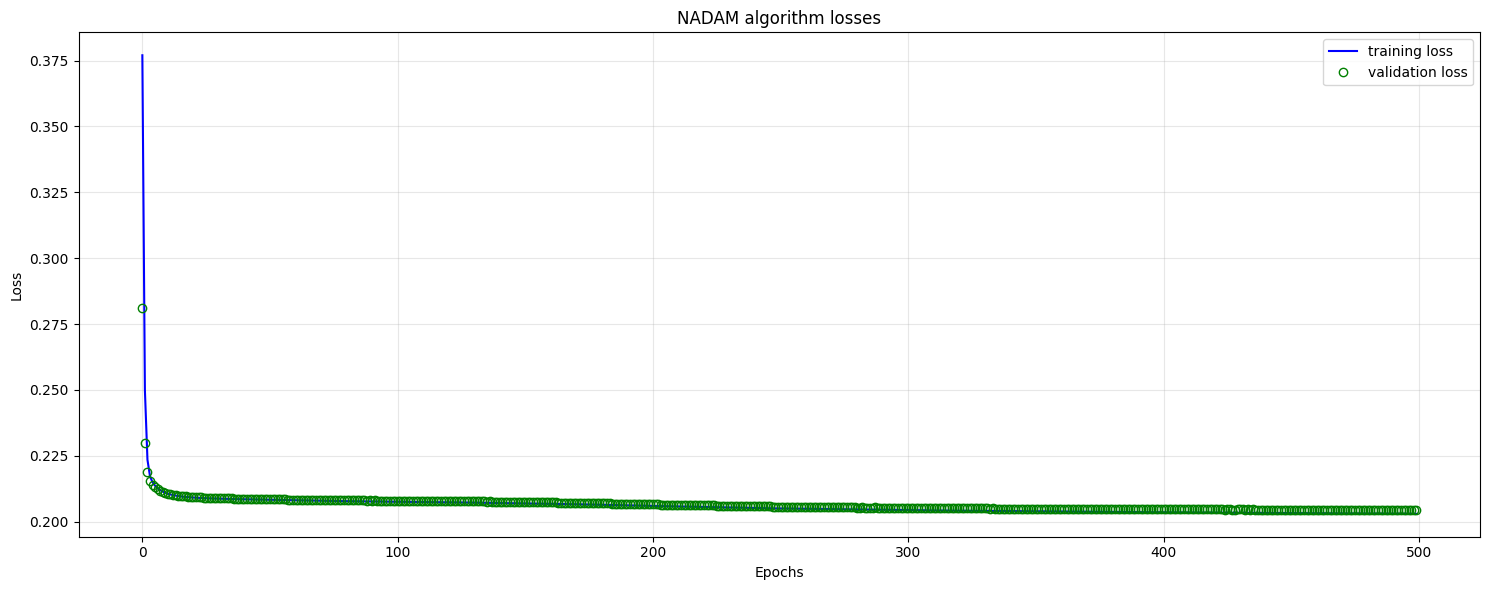

In [31]:
#costruzione rete
model_input = Input(shape = (X_trainSC.shape[1],), name = "regressori", dtype = "float32")
exposure_input = Input(shape = (1,), name = "exposure")
x = Dense(20, activation = "tanh")(model_input)
x = Dense(1, activation ="exponential" )(x)
output = Multiply()([x,exposure_input])
nn = Model(inputs = [model_input,exposure_input], outputs = output)
nn.compile(loss = "poisson", optimizer = Nadam())
print(nn.summary())

checkpoint_path = "nn.weights_shallow.weights.h5"

#per salvare in automatico i pesi con la validation loss più bassa
checkpoint1 = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor="val_loss",
    verbose=0,
    save_best_only=True,
    save_weights_only=True
)


fit = nn.fit(
    x=[X_trainSC, train["Exposure"]],
    y=y,
    validation_split=0.2,
    batch_size=10000,
    epochs=500,
    verbose=0,
    callbacks=[checkpoint1]
)

#carico i pesi del modello con validation loss più piccola
nn.load_weights(checkpoint_path)

fig, ax = plt.subplots()
ax.plot(fit.epoch,fit.history["loss"], color = "blue", linestyle = "-", label = "training loss")
ax.plot(fit.epoch,fit.history["val_loss"], marker="o",markerfacecolor="none",markeredgecolor="green", label = "validation loss",linestyle="")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.set_title("NADAM algorithm losses")
ax.grid(alpha=.3)
ax.legend()
plt.show(block=True)


Mappa dei pesi dello shallow Neural Net

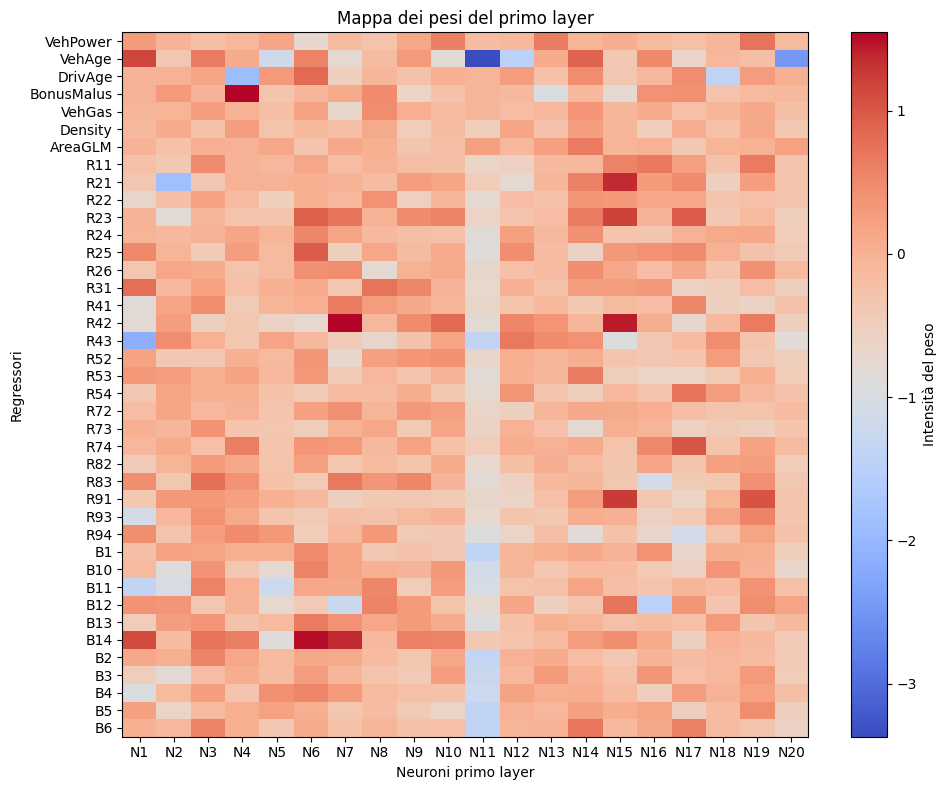

In [32]:
pesi = np.array(nn.weights[0])
plt.figure(figsize=(10, 8))
im = plt.imshow(pesi, aspect="auto", cmap="coolwarm", interpolation="nearest")
plt.colorbar(im, label="Intensità del peso")
plt.xticks(np.arange(pesi.shape[1]), [f"N{i+1}" for i in range(pesi.shape[1])], rotation=0)
plt.yticks(np.arange(pesi.shape[0]), list(X_trainSC.columns))
plt.xlabel("Neuroni primo layer")
plt.ylabel("Regressori")
plt.title("Mappa dei pesi del primo layer")
plt.tight_layout()
plt.show(block=True)


In [33]:
prediction_train_nn = nn.predict(x = [X_trainSC,train["Exposure"]])
prediction_test_nn = nn.predict(x = [X_testSC,test["Exposure"]])
loss_nn = mean_poisson_deviance(train["ClaimNb"], prediction_train_nn)
print(f"In-sample poisson deviance loss:{loss_nn}")
oos_loss_nn = mean_poisson_deviance(test["ClaimNb"],prediction_test_nn)
print(f"Out-of-sample poisson deviance loss:{oos_loss_nn}")

tab_conf_nn_shallow = pd.concat([pd.DataFrame(np.array([loss_nn,loss_GLMboost,loss_boost3, loss_tree2,loss_tree1000,loss1])),
                            pd.DataFrame(np.array([oos_loss_nn,oos_loss_GLMboost,loss_boost3_test, oos_loss_tree2,oos_loss_tree1000,oos_loss1]))]
                            ,axis = 1)
tab_conf_nn_shallow.columns = ["in-sample loss", "out-of-sample loss"]
tab_conf_nn_shallow.index = ["nn_shallow","Model GLMboost","Model PBM3 (depth J = 3, iterations M = 50)", "Model RT Min CV rule", "Model RT 1000","Model GLM1"]
print(tab_conf_nn_shallow)


19070/19070 ━━━━━━━━━━━━━━━━━━━━ 16s 856us/step
2119/2119 ━━━━━━━━━━━━━━━━━━━━ 2s 892us/step
In-sample poisson deviance loss:0.30876699114832307
Out-of-sample poisson deviance loss:0.3143445368241528
                                             in-sample loss  \
nn_shallow                                         0.308767   
Model GLMboost                                     0.303898   
Model PBM3 (depth J = 3, iterations M = 50)        0.303806   
Model RT Min CV rule                               0.308950   
Model RT 1000                                      0.305080   
Model GLM1                                         0.314087   

                                             out-of-sample loss  
nn_shallow                                             0.314345  
Model GLMboost                                         0.309393  
Model PBM3 (depth J = 3, iterations M = 50)            0.309465  
Model RT Min CV rule                                   0.313622  
Model RT 1000               

Deep Neural Net

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ regressori (InputLayer)       │ (None, 40)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer1 (Dense)                │ (None, 20)                │             820 │ regressori[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer2 (Dense)                │ (None, 15)                │             315 │ layer1[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer3 (Dense)                │ (None, 10)                │             160 │ layer2[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 1)                 │              11 │ layer3[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ exposure (InputLayer)         │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multiply_1 (Multiply)         │ (None, 1)                 │               0 │ dense_2[0][0],             │
│                               │                           │                 │ exposure[0][0]             │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 1,306 (5.10 KB)

 Trainable params: 1,306 (5.10 KB)

 Non-trainable params: 0 (0.00 B)

None


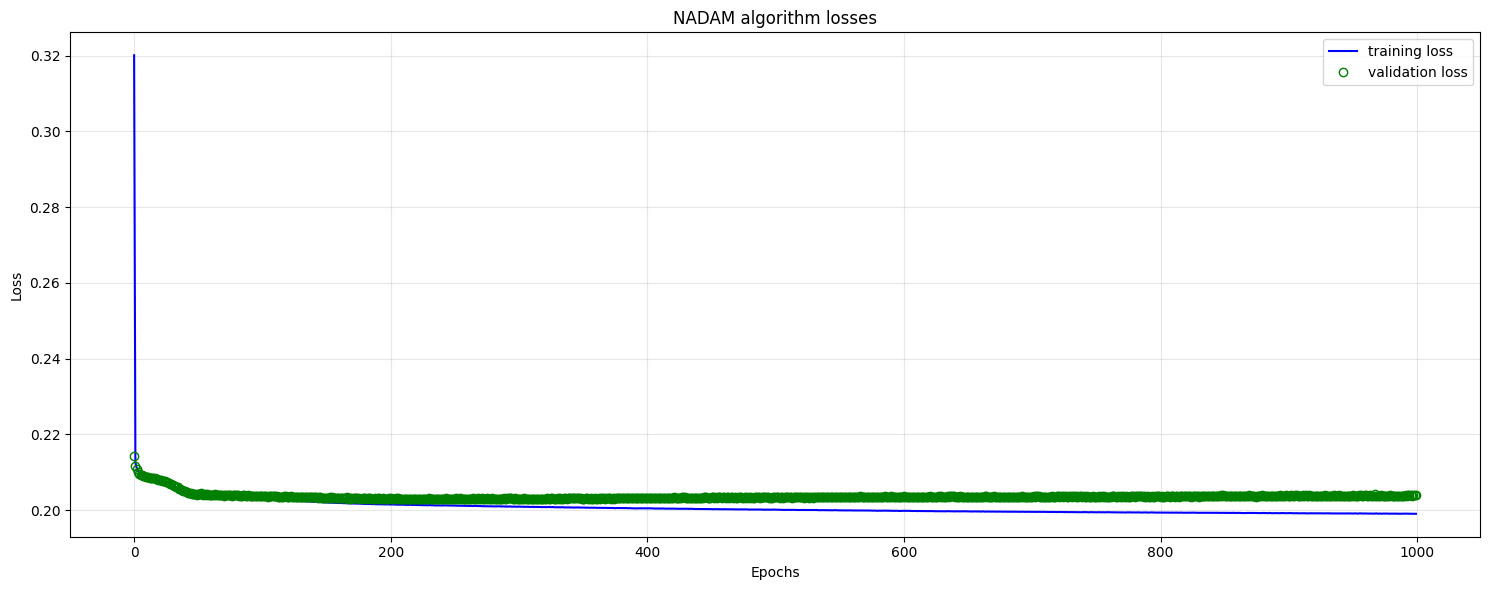

In [34]:
#----------------Deep network------------------------------------------
model_input = Input(shape = (X_trainSC.shape[1],), name = "regressori", dtype = "float32")
exposure_input = Input(shape = (1,), name = "exposure")
x = Dense(20, activation = "tanh", name = "layer1")(model_input)
x = Dense(15, activation = "tanh", name = "layer2")(x)
x = Dense(10, activation = "tanh", name = "layer3")(x)
x = Dense(1, activation ="exponential" )(x)
output = Multiply()([x,exposure_input])
nn_deep = Model(inputs = [model_input,exposure_input], outputs = output)
nn_deep.compile(loss = "poisson", optimizer = Nadam())
print(nn_deep.summary())

checkpoint_path = "nn.weights_deep.weights.h5"

checkpoint1 = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor="val_loss",
    verbose=0,
    save_best_only=True,
    save_weights_only=True
)

fit = nn_deep.fit(
    x=[X_trainSC, train["Exposure"]],
    y=y,
    validation_split=0.2,
    batch_size=5000,
    epochs=1000,
    verbose=0,
    callbacks=[checkpoint1]
)

#carico i pesi del modello con validation loss più piccola
nn_deep.load_weights(checkpoint_path)

fig, ax = plt.subplots()
ax.plot(fit.epoch,fit.history["loss"], color = "blue", linestyle = "-", label = "training loss")
ax.plot(fit.epoch,fit.history["val_loss"], marker="o",markerfacecolor="none",markeredgecolor="green", label = "validation loss",linestyle="")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.set_title("NADAM algorithm losses")
ax.grid(alpha=.3)
ax.legend()
plt.show(block=True)


In [35]:
prediction_train_nndeep = nn_deep.predict(x = [X_trainSC,train["Exposure"]])
prediction_test_nndeep = nn_deep.predict(x = [X_testSC,test["Exposure"]])
loss_nn_deep = mean_poisson_deviance(train["ClaimNb"], prediction_train_nndeep)
print(f"In-sample poisson deviance loss:{loss_nn_deep}")
oos_loss_nn_deep = mean_poisson_deviance(test["ClaimNb"],prediction_test_nndeep)
print(f"Out-of-sample poisson deviance loss:{oos_loss_nn_deep}")

tab_conf_nn_deep = pd.concat([pd.DataFrame(np.array([loss_nn_deep,loss_nn,loss_GLMboost,loss_boost3, loss_tree2,loss_tree1000,loss1])),
                            pd.DataFrame(np.array([oos_loss_nn_deep,oos_loss_nn,oos_loss_GLMboost,loss_boost3_test, oos_loss_tree2,oos_loss_tree1000,oos_loss1]))]
                            ,axis = 1)
tab_conf_nn_deep.columns = ["in-sample loss", "out-of-sample loss"]
tab_conf_nn_deep.index = ["nn_deep","nn_shallow","Model GLMboost","Model PBM3 (depth J = 3, iterations M = 50)", "Model RT Min CV rule", "Model RT 1000","Model GLM1"]
print(tab_conf_nn_deep)


19070/19070 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step
2119/2119 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step  
In-sample poisson deviance loss:0.30533461137231116
Out-of-sample poisson deviance loss:0.31274108136376455
                                             in-sample loss  \
nn_deep                                            0.305335   
nn_shallow                                         0.308767   
Model GLMboost                                     0.303898   
Model PBM3 (depth J = 3, iterations M = 50)        0.303806   
Model RT Min CV rule                               0.308950   
Model RT 1000                                      0.305080   
Model GLM1                                         0.314087   

                                             out-of-sample loss  
nn_deep                                                0.312741  
nn_shallow                                             0.314345  
Model GLMboost                                         0.309393  
Model PBM3 (depth J = 3, iterati

Stratified Batch: un applicazione alla poisson

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ regressori (InputLayer)       │ (None, 40)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer1 (Dense)                │ (None, 20)                │             820 │ regressori[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer2 (Dense)                │ (None, 15)                │             315 │ layer1[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer3 (Dense)                │ (None, 10)                │             160 │ layer2[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_3 (Dense)               │ (None, 1)                 │              11 │ layer3[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ exposure (InputLayer)         │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multiply_2 (Multiply)         │ (None, 1)                 │               0 │ dense_3[0][0],             │
│                               │                           │                 │ exposure[0][0]             │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 1,306 (5.10 KB)

 Trainable params: 1,306 (5.10 KB)

 Non-trainable params: 0 (0.00 B)

None


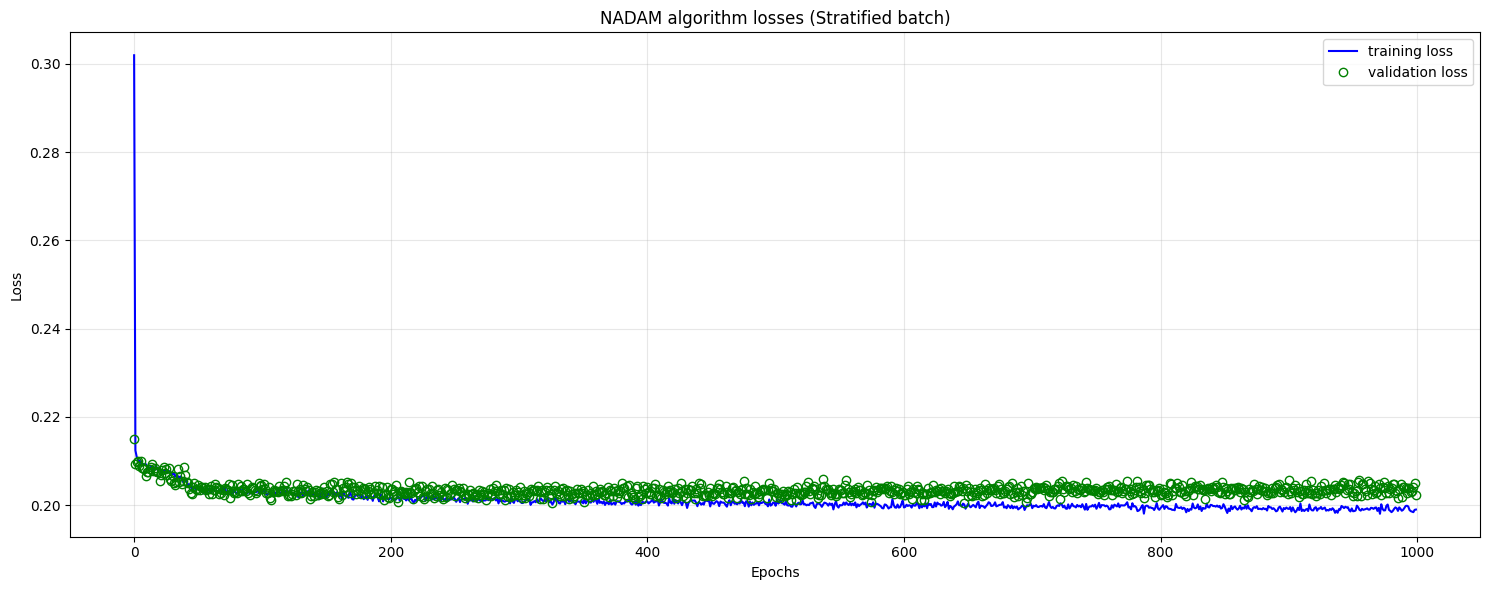

In [36]:
class StratifiedBatchGenerator(tf.keras.utils.Sequence):
    def __init__(self, X: pd.DataFrame, y: pd.Series, exposure: pd.Series,
                 batch_size=1024, ratio: float = 0.1, shuffle=True):
        super().__init__()  #non so perchè ma ese un warning se non faccio così
        self.X = X.reset_index(drop=True)
        self.y = y.reset_index(drop=True)
        self.exposure = exposure.reset_index(drop=True)
        self.batch_size = batch_size
        self.ratio = ratio
        self.shuffle = shuffle

        self.zero_idx = self.y[self.y == 0].index.values
        self.nonzero_idx = self.y[self.y > 0].index.values

        self.steps = len(y) // batch_size
        self.on_epoch_end()

    def __len__(self):
        return self.steps

    def __getitem__(self, idx):
        pos_per_batch = round(self.batch_size * self.ratio)
        neg_per_batch = self.batch_size - pos_per_batch

        idx_zero = np.random.choice(self.zero_idx, neg_per_batch, replace=False)
        idx_nonzero = np.random.choice(self.nonzero_idx, pos_per_batch, replace=False)

        batch_idx = np.concatenate([idx_zero, idx_nonzero], axis=0)
        np.random.shuffle(batch_idx)

        X_batch = self.X.iloc[batch_idx, :].values
        exposure_batch = self.exposure.iloc[batch_idx].values.reshape(-1, 1)
        y_batch = self.y.iloc[batch_idx].values


        return (X_batch, exposure_batch), y_batch

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.zero_idx)
            np.random.shuffle(self.nonzero_idx)
#test sulla rete esposta nel paper: Insights from Inside Neural Networks di Andrea Ferrario et. al

model_input = Input(shape = (X_trainSC.shape[1],), name = "regressori", dtype = "float32")
exposure_input = Input(shape = (1,), name = "exposure")
x = Dense(20, activation = "tanh", name = "layer1")(model_input)
x = Dense(15, activation = "tanh", name = "layer2")(x)
x = Dense(10, activation = "tanh", name = "layer3")(x)
x = Dense(1, activation ="exponential" )(x)
output = Multiply()([x,exposure_input])
nn_StratBatch = Model(inputs = [model_input,exposure_input], outputs = output)
nn_StratBatch.compile(loss = "poisson", optimizer = Nadam())
print(nn_StratBatch.summary())

random.seed(100)
lv = random.sample(list(X_trainSC.index), round(X_trainSC.shape[0]*0.8 ))
X_train = X_trainSC.loc[lv,:]
X_val = X_trainSC.drop(index=lv)
y_train = y.loc[lv]
y_val = y.drop(index = lv)
exposure_train = train["Exposure"].loc[lv]
exposure_val  = train["Exposure"].drop(index = lv)
ratio = y.loc[y.values>=1].count()/y.shape[0]
generator_train = StratifiedBatchGenerator(X_train, y_train, exposure_train,batch_size=5000, ratio=ratio)
generator_val = StratifiedBatchGenerator(X_val,y_val, exposure_val,batch_size=5000,ratio = ratio)

checkpoint_path = "nn_StratBatch.weights.h5"

checkpoint1 = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    verbose=0,
    save_best_only=True,
    save_weights_only=True
)
fit = nn_StratBatch.fit(
    generator_train,
    epochs=1000,
    validation_data = generator_val,
    verbose=0,
    callbacks=[checkpoint1]
)

#carico i pesi del modello con validation loss più piccola
nn_StratBatch.load_weights(checkpoint_path)

fig, ax = plt.subplots()
ax.plot(fit.epoch,fit.history["loss"], color = "blue", linestyle = "-", label = "training loss")
ax.plot(fit.epoch,fit.history["val_loss"], marker="o",markerfacecolor="none",markeredgecolor="green", label = "validation loss",linestyle="")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.set_title("NADAM algorithm losses (Stratified batch)")
ax.grid(alpha=.3)
ax.legend()
plt.show(block=True)


In [37]:
prediction_train_stratbatch = nn_StratBatch.predict(x = [X_trainSC,train["Exposure"]])
prediction_test_stratbatch = nn_StratBatch.predict(x = [X_testSC,test["Exposure"]])
loss_nn_stratbatch = mean_poisson_deviance(train["ClaimNb"], prediction_train_stratbatch)
print(f"In-sample poisson deviance loss:{loss_nn_stratbatch}")
oos_loss_nn_stratbatch = mean_poisson_deviance(test["ClaimNb"],prediction_test_stratbatch)
print(f"Out-of-sample poisson deviance loss:{oos_loss_nn_stratbatch}")

tab_conf_nn_stratbatch = pd.concat([pd.DataFrame(np.array([loss_nn_stratbatch,loss_nn_deep,loss_nn,loss_GLMboost,loss_boost3, loss_tree2,loss_tree1000,loss1])),
                            pd.DataFrame(np.array([oos_loss_nn_stratbatch,oos_loss_nn_deep,oos_loss_nn,oos_loss_GLMboost,loss_boost3_test, oos_loss_tree2,oos_loss_tree1000,oos_loss1]))]
                            ,axis = 1)
tab_conf_nn_stratbatch.columns = ["in-sample loss", "out-of-sample loss"]
tab_conf_nn_stratbatch.index = ["nn_strat_batch","nn_deep","nn_shallow","Model GLMboost","Model PBM3 (depth J = 3, iterations M = 50)", "Model RT Min CV rule", "Model RT 1000","Model GLM1"]
print(tab_conf_nn_stratbatch)


19070/19070 ━━━━━━━━━━━━━━━━━━━━ 17s 900us/step
2119/2119 ━━━━━━━━━━━━━━━━━━━━ 2s 910us/step
In-sample poisson deviance loss:0.30475411283286585
Out-of-sample poisson deviance loss:0.313316581188389
                                             in-sample loss  \
nn_strat_batch                                     0.304754   
nn_deep                                            0.305335   
nn_shallow                                         0.308767   
Model GLMboost                                     0.303898   
Model PBM3 (depth J = 3, iterations M = 50)        0.303806   
Model RT Min CV rule                               0.308950   
Model RT 1000                                      0.305080   
Model GLM1                                         0.314087   

                                             out-of-sample loss  
nn_strat_batch                                         0.313317  
nn_deep                                                0.312741  
nn_shallow                         

Ridge Regression L2 Norm

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ regressori (InputLayer)       │ (None, 40)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer1 (Dense)                │ (None, 20)                │             820 │ regressori[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer2 (Dense)                │ (None, 15)                │             315 │ layer1[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer3 (Dense)                │ (None, 10)                │             160 │ layer2[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_4 (Dense)               │ (None, 1)                 │              11 │ layer3[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ exposure (InputLayer)         │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multiply_3 (Multiply)         │ (None, 1)                 │               0 │ dense_4[0][0],             │
│                               │                           │                 │ exposure[0][0]             │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 1,306 (5.10 KB)

 Trainable params: 1,306 (5.10 KB)

 Non-trainable params: 0 (0.00 B)

None


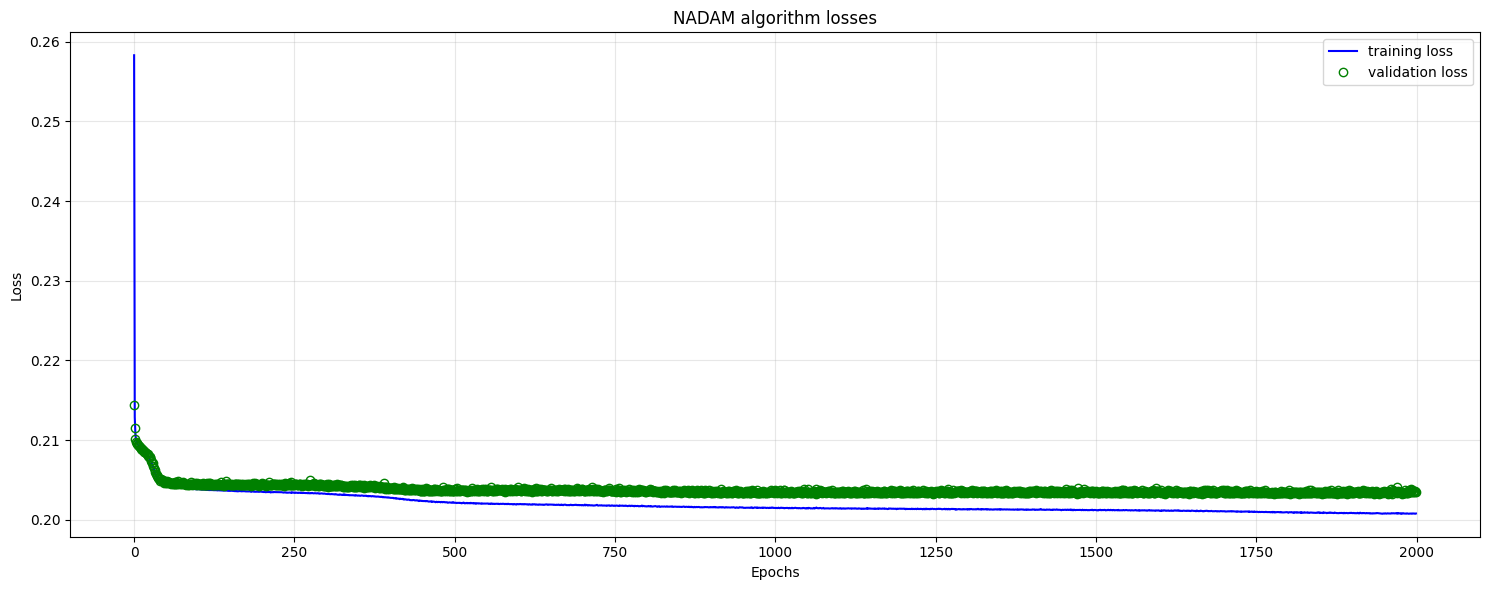

In [38]:
#-------costruzione di un modello regolarizzato con norma L2 (ridge regression)-------------------

model_input = Input(shape = (X_trainSC.shape[1],), name = "regressori", dtype = "float32")
exposure_input = Input(shape = (1,), name = "exposure")
x = Dense(20, activation = "tanh", name = "layer1", kernel_regularizer=regularizers.L2(0.00001))(model_input)
x = Dense(15, activation = "tanh", name = "layer2", kernel_regularizer=regularizers.L2(0.00001))(x)
x = Dense(10, activation = "tanh", name = "layer3", kernel_regularizer=regularizers.L2(0.00001))(x)
x = Dense(1, activation ="exponential" )(x)
output = Multiply()([x,exposure_input])
nn_regularized = Model(inputs = [model_input,exposure_input], outputs = output)
nn_regularized.compile(loss = "poisson", optimizer = Nadam())
print(nn_regularized.summary())

checkpoint_path = "nn.weights_regularized.weights.h5"

#per salvare in automatico i pesi con la validation loss più bassa
checkpoint1 = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor="val_loss",
    verbose=0,
    save_best_only=True,
    save_weights_only=True
)

fit = nn_regularized.fit(
    x=[X_trainSC, train["Exposure"]],
    y=y,
    validation_split=0.2,
    batch_size=5000,
    epochs=2000,
    verbose=0,
    callbacks=[checkpoint1]
)

#carico i pesi del modello con validation loss più piccola
nn_regularized.load_weights(checkpoint_path)

fig, ax = plt.subplots()
ax.plot(fit.epoch,fit.history["loss"], color = "blue", linestyle = "-", label = "training loss")
ax.plot(fit.epoch,fit.history["val_loss"], marker="o",markerfacecolor="none",markeredgecolor="green", label = "validation loss",linestyle="")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.set_title("NADAM algorithm losses")
ax.grid(alpha=.3)
ax.legend()
plt.show(block=True)


In [39]:
prediction_train_nnregularized = nn_regularized.predict(x = [X_trainSC,train["Exposure"]])
prediction_test_nnregularized = nn_regularized.predict(x = [X_testSC,test["Exposure"]])
loss_nn_regularized = mean_poisson_deviance(train["ClaimNb"], prediction_train_nnregularized)
print(f"In-sample poisson deviance loss:{loss_nn_regularized}")
oos_loss_nn_regularized = mean_poisson_deviance(test["ClaimNb"],prediction_test_nnregularized)
print(f"Out-of-sample poisson deviance loss:{oos_loss_nn_regularized}")

tab_conf_nn_regularized = pd.concat([pd.DataFrame(np.array([loss_nn_regularized,loss_nn_stratbatch,loss_nn_deep,loss_nn,loss_GLMboost,loss_boost3, loss_tree2,loss_tree1000,loss1])),
                            pd.DataFrame(np.array([oos_loss_nn_regularized,oos_loss_nn_stratbatch,oos_loss_nn_deep,oos_loss_nn,oos_loss_GLMboost,loss_boost3_test, oos_loss_tree2,oos_loss_tree1000,oos_loss1]))]
                            ,axis = 1)
tab_conf_nn_regularized.columns = ["in-sample loss", "out-of-sample loss"]
tab_conf_nn_regularized.index = ["nn_regularized","nn_strat_batch","nn_deep","nn_shallow","Model GLMboost","Model PBM3 (depth J = 3, iterations M = 50)", "Model RT Min CV rule", "Model RT 1000","Model GLM1"]
print(tab_conf_nn_regularized)


19070/19070 ━━━━━━━━━━━━━━━━━━━━ 17s 886us/step
2119/2119 ━━━━━━━━━━━━━━━━━━━━ 2s 894us/step
In-sample poisson deviance loss:0.30208934089496864
Out-of-sample poisson deviance loss:0.31132120457315393
                                             in-sample loss  \
nn_regularized                                     0.302089   
nn_strat_batch                                     0.304754   
nn_deep                                            0.305335   
nn_shallow                                         0.308767   
Model GLMboost                                     0.303898   
Model PBM3 (depth J = 3, iterations M = 50)        0.303806   
Model RT Min CV rule                               0.308950   
Model RT 1000                                      0.305080   
Model GLM1                                         0.314087   

                                             out-of-sample loss  
nn_regularized                                         0.311321  
nn_strat_batch                      

Modelli con dropout layers (1%,2%,5%,10%)

19070/19070 ━━━━━━━━━━━━━━━━━━━━ 18s 958us/step
2119/2119 ━━━━━━━━━━━━━━━━━━━━ 2s 953us/step
In-sample poisson deviance loss:0.30450488614520527
Out-of-sample poisson deviance loss:0.31242264740817366
19070/19070 ━━━━━━━━━━━━━━━━━━━━ 19s 976us/step
2119/2119 ━━━━━━━━━━━━━━━━━━━━ 2s 992us/step
In-sample poisson deviance loss:0.3048050752109698
Out-of-sample poisson deviance loss:0.3126180257598331
19070/19070 ━━━━━━━━━━━━━━━━━━━━ 19s 972us/step
2119/2119 ━━━━━━━━━━━━━━━━━━━━ 2s 995us/step
In-sample poisson deviance loss:0.3057008022855781
Out-of-sample poisson deviance loss:0.312017767588207
19070/19070 ━━━━━━━━━━━━━━━━━━━━ 18s 967us/step
2119/2119 ━━━━━━━━━━━━━━━━━━━━ 2s 967us/step
In-sample poisson deviance loss:0.30554982699731803
Out-of-sample poisson deviance loss:0.31225024287393205


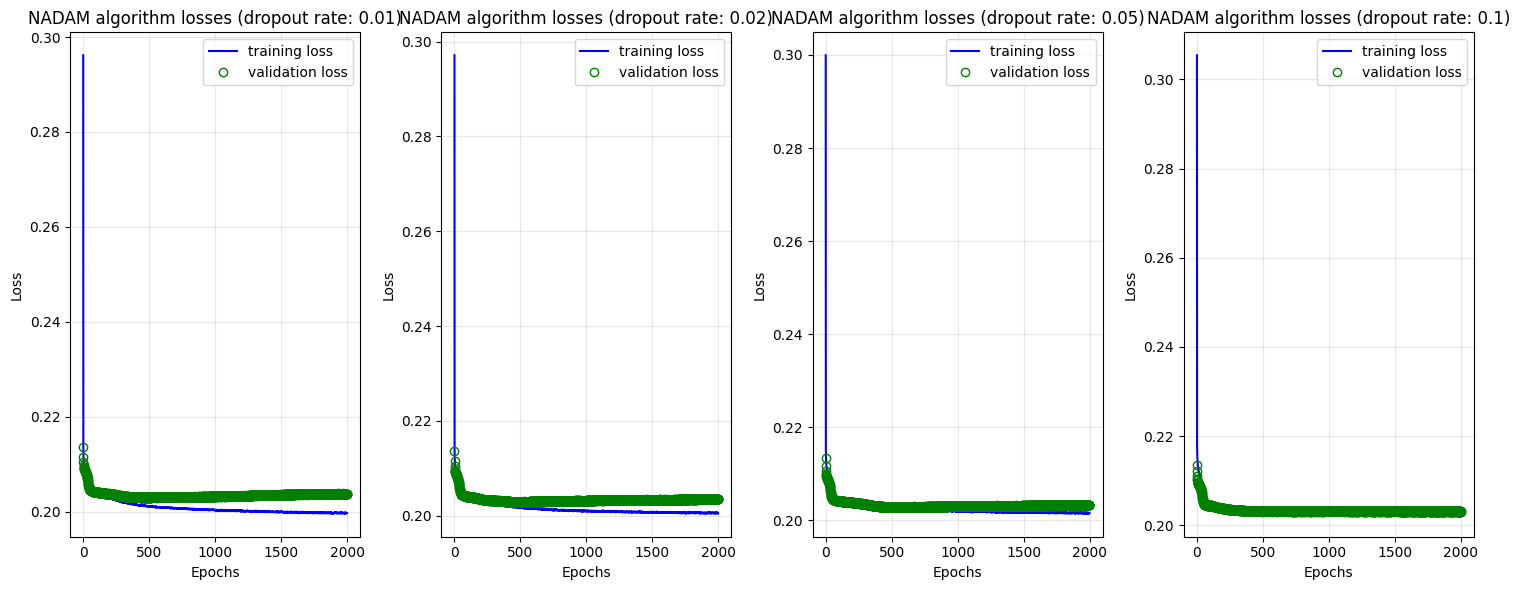

In [40]:
dropout_rate = [.01,.02,.05,.1]
lossTrain_dropout = {}
lossVal_dropout = {}
for rate in dropout_rate:
    random.seed(100)
    np.random.seed(100)
    tf.random.set_seed(100)

    model_input = Input(shape=(X_trainSC.shape[1],), name="regressori", dtype="float32")
    exposure_input = Input(shape=(1,), name="exposure")
    x = Dense(20, activation="tanh", name="layer1" )(model_input)
    x = Dropout(rate)(x)
    x = Dense(15, activation="tanh", name="layer2" )(x)
    x = Dropout(rate)(x)
    x = Dense(10, activation="tanh", name="layer3")(x)
    x = Dropout(rate)(x)
    x = Dense(1, activation="exponential")(x)
    output = Multiply()([x, exposure_input])
    nn_dropout = Model(inputs=[model_input, exposure_input], outputs=output)
    nn_dropout.compile(loss="poisson", optimizer=Nadam())

    checkpoint_path = f"nn.weights_dropout{rate}.weights.h5"

    # per salvare in automatico i pesi con la validation loss più bassa
    checkpoint1 = ModelCheckpoint(
        filepath=checkpoint_path,
        monitor="val_loss",
        verbose=0,
        save_best_only=True,
        save_weights_only=True
    )

    fit = nn_dropout.fit(
        x=[X_trainSC, train["Exposure"]],
        y=y,
        validation_split=0.2,
        batch_size=5000,
        epochs=2000,
        verbose=0,
        callbacks=[checkpoint1]
    )
    lossTrain_dropout[f"{rate}"] = fit.history["loss"]
    lossVal_dropout[f"{rate}"] = fit.history["val_loss"]

loss_nn_dropout = {}
oos_loss_nn_dropout = {}

fig, ax = plt.subplots(nrows=1, ncols=4)
for i,rate in enumerate(dropout_rate):
    ax[i].plot(fit.epoch, lossTrain_dropout[f"{rate}"], color="blue", linestyle="-", label="training loss")
    ax[i].plot(fit.epoch, lossVal_dropout[f"{rate}"], marker="o", markerfacecolor="none", markeredgecolor="green",
               label="validation loss", linestyle="")
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel("Loss")
    ax[i].set_title(f"NADAM algorithm losses (dropout rate: {rate})")
    ax[i].grid(alpha=.3)
    ax[i].legend()

    nn_dropout.load_weights(f"nn.weights_dropout{rate}.weights.h5")

    prediction_train_dropout = nn_dropout.predict(x=[X_trainSC, train["Exposure"]])
    prediction_test_dropout = nn_dropout.predict(x=[X_testSC, test["Exposure"]])
    loss_nn_dropout[f"{rate}"] = mean_poisson_deviance(train["ClaimNb"], prediction_train_dropout)
    print(f"In-sample poisson deviance loss:{loss_nn_dropout[f'{rate}']}")
    oos_loss_nn_dropout[f"{rate}"] = mean_poisson_deviance(test["ClaimNb"], prediction_test_dropout)
    print(f"Out-of-sample poisson deviance loss:{oos_loss_nn_dropout[f'{rate}']}")
plt.show(block=True)


Analisi Rielaborazioni Input Ottenute dal Network

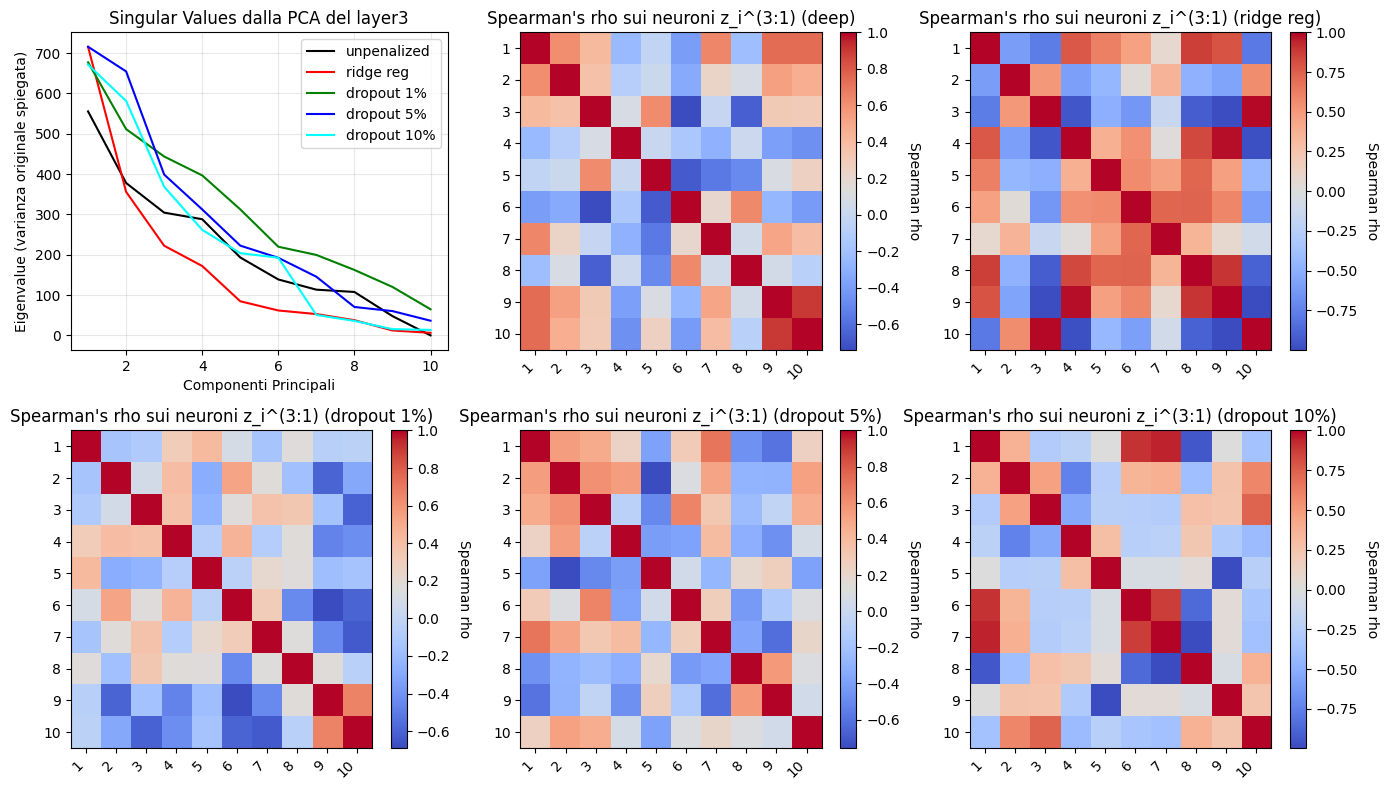

In [41]:
#-------------------- Analisi delle rielaborazioni dei network ---------------------------

intermediate_model = Model(inputs=[model_input, exposure_input], outputs=nn_dropout.get_layer("layer3").output)

intermediate_model.load_weights("nn.weights_deep.weights.h5")
RRnn_Deep = intermediate_model.predict(x=[X_trainSC, train["Exposure"]] ,verbose=0)
intermediate_model.load_weights("nn_regularized.weights.h5")
RRnn_Reg = intermediate_model.predict(x=[X_trainSC, train["Exposure"]] ,verbose=0)
intermediate_model.load_weights("nn.weights_dropout0.01.weights.h5")
RRnn_01 = intermediate_model.predict(x=[X_trainSC, train["Exposure"]] ,verbose=0)
intermediate_model.load_weights("nn.weights_dropout0.05.weights.h5")
RRnn_05 = intermediate_model.predict(x=[X_trainSC, train["Exposure"]] ,verbose=0)
intermediate_model.load_weights("nn.weights_dropout0.1.weights.h5")
RRnn_1 = intermediate_model.predict(x=[X_trainSC, train["Exposure"]] ,verbose=0)

pca_deep = PCA().fit(RRnn_Deep)
singular_values_deep = pca_deep.singular_values_
pca_reg = PCA().fit(RRnn_Reg)
singular_values_reg = pca_reg.singular_values_
pca_01 = PCA().fit(RRnn_01)
singular_values_01 = pca_01.singular_values_
pca_05 = PCA().fit(RRnn_05)
singular_values_05 = pca_05.singular_values_
pca_1 = PCA().fit(RRnn_1)
singular_values_1 = pca_1.singular_values_

spear_deep, pval = spearmanr(RRnn_Deep)
spear_reg, pval = spearmanr(RRnn_Reg)
spear_01, pval = spearmanr(RRnn_01)
spear_05, pval = spearmanr(RRnn_05)
spear_1, pval = spearmanr(RRnn_1)



fig, ax = plt.subplots(nrows=2,ncols=3, figsize = (14,8))
ax[0,0].plot(np.arange(len(singular_values_deep))+1, singular_values_deep, color="black",label = "unpenalized")
ax[0,0].plot(np.arange(len(singular_values_deep))+1, singular_values_reg, color="red",label = "ridge reg")
ax[0,0].plot(np.arange(len(singular_values_deep))+1, singular_values_01, color="green",label = "dropout 1%")
ax[0,0].plot(np.arange(len(singular_values_deep))+1, singular_values_05, color="blue",label = "dropout 5%")
ax[0,0].plot(np.arange(len(singular_values_deep))+1, singular_values_1, color="cyan",label = "dropout 10%")
ax[0,0].set_xlabel("Componenti Principali")
ax[0,0].set_ylabel("Eigenvalue (varianza originale spiegata)")
ax[0,0].set_title('Singular Values dalla PCA del layer3')
ax[0,0].legend()
ax[0,0].grid(alpha=.3)

im = ax[0,1].imshow(spear_deep, cmap="coolwarm", aspect="auto", interpolation="nearest")
cbar = fig.colorbar(im, ax=ax[0,1])
cbar.set_label("Spearman rho", rotation=270, labelpad=15)
ax[0,1].set_xticks(np.arange(10))
ax[0,1].set_yticks(np.arange(10))
ax[0,1].set_xticklabels(np.arange(10)+1, rotation=45, ha="right")
ax[0,1].set_yticklabels(np.arange(10)+1)
ax[0,1].set_title("Spearman's rho sui neuroni z_i^(3:1) (deep)")

im = ax[0,2].imshow(spear_reg, cmap="coolwarm", aspect="auto", interpolation="nearest")
cbar = fig.colorbar(im, ax=ax[0,2])
cbar.set_label("Spearman rho", rotation=270, labelpad=15)
ax[0,2].set_xticks(np.arange(10))
ax[0,2].set_yticks(np.arange(10))
ax[0,2].set_xticklabels(np.arange(10)+1, rotation=45, ha="right")
ax[0,2].set_yticklabels(np.arange(10)+1)
ax[0,2].set_title("Spearman's rho sui neuroni z_i^(3:1) (ridge reg)")

im = ax[1,0].imshow(spear_01, cmap="coolwarm", aspect="auto", interpolation="nearest")
cbar = fig.colorbar(im, ax=ax[1,0])
cbar.set_label("Spearman rho", rotation=270, labelpad=15)
ax[1,0].set_xticks(np.arange(10))
ax[1,0].set_yticks(np.arange(10))
ax[1,0].set_xticklabels(np.arange(10)+1, rotation=45, ha="right")
ax[1,0].set_yticklabels(np.arange(10)+1)
ax[1,0].set_title("Spearman's rho sui neuroni z_i^(3:1) (dropout 1%)")

im = ax[1,1].imshow(spear_05, cmap="coolwarm", aspect="auto", interpolation="nearest")
cbar = fig.colorbar(im, ax=ax[1,1])
cbar.set_label("Spearman rho", rotation=270, labelpad=15)
ax[1,1].set_xticks(np.arange(10))
ax[1,1].set_yticks(np.arange(10))
ax[1,1].set_xticklabels(np.arange(10)+1, rotation=45, ha="right")
ax[1,1].set_yticklabels(np.arange(10)+1)
ax[1,1].set_title("Spearman's rho sui neuroni z_i^(3:1) (dropout 5%)")

im = ax[1,2].imshow(spear_1, cmap="coolwarm", aspect="auto", interpolation="nearest")
cbar = fig.colorbar(im, ax=ax[1,2])
cbar.set_label("Spearman rho", rotation=270, labelpad=15)
ax[1,2].set_xticks(np.arange(10))
ax[1,2].set_yticks(np.arange(10))
ax[1,2].set_xticklabels(np.arange(10)+1, rotation=45, ha="right")
ax[1,2].set_yticklabels(np.arange(10)+1)
ax[1,2].set_title("Spearman's rho sui neuroni z_i^(3:1) (dropout 10%)")

plt.tight_layout()

plt.show(block = True)


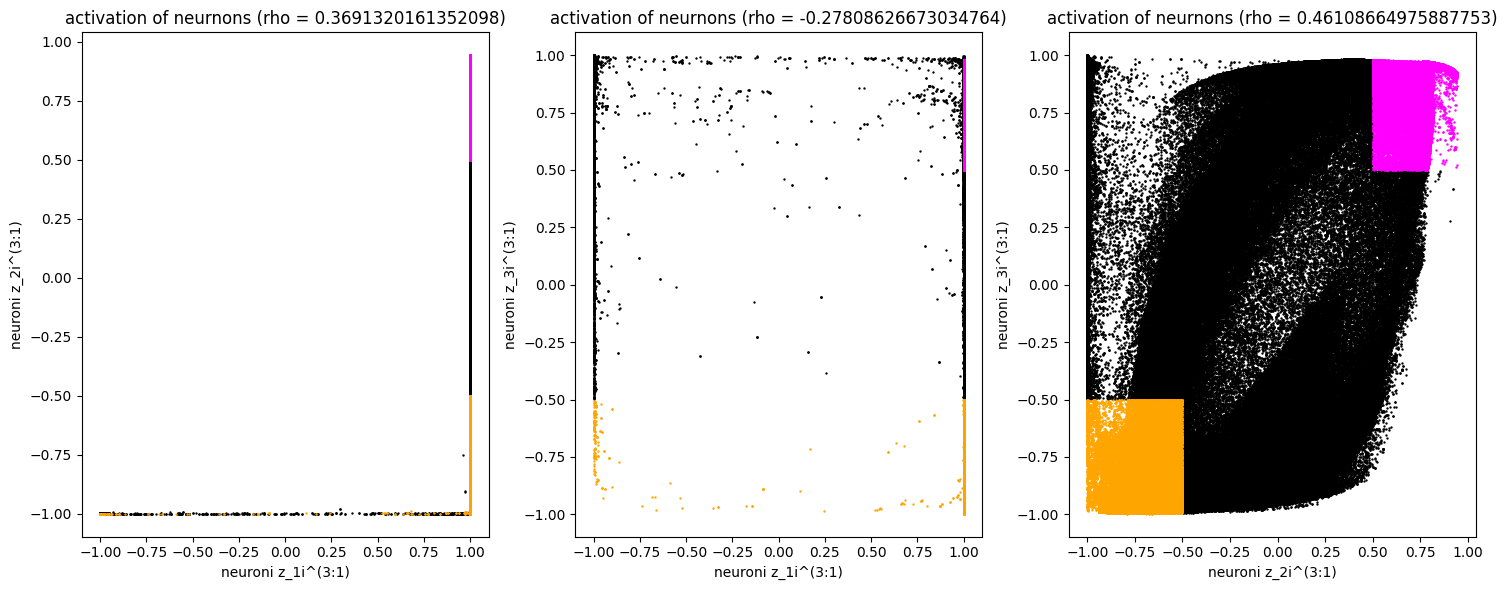

In [44]:
orange_pos = np.max(RRnn_1[:,[1,2]],axis = 1) <= -.5
magenta_pos = np.min(RRnn_1[:,[1,2]],axis = 1) >=.5
neutral_pos = ~(orange_pos | magenta_pos)
fig,ax = plt.subplots(nrows=1, ncols = 3)
ax[0].scatter(x = RRnn_1[neutral_pos,0],y = RRnn_1[neutral_pos,1],color = "black",s=.5)
ax[0].scatter(x = RRnn_1[orange_pos,0],y = RRnn_1[orange_pos,1],color = "orange",s=.5)
ax[0].scatter(x = RRnn_1[magenta_pos,0],y = RRnn_1[magenta_pos,1],color = "magenta",s=.5)
ax[0].set_xlabel("neuroni z_1i^(3:1)")
ax[0].set_ylabel("neuroni z_2i^(3:1)")
ax[0].set_title(f"activation of neurnons (rho = {spear_1[0,1]})")

ax[1].scatter(x = RRnn_1[neutral_pos,0],y = RRnn_1[neutral_pos,2],color = "black",s=.5)
ax[1].scatter(x = RRnn_1[orange_pos,0],y = RRnn_1[orange_pos,2],color = "orange",s=.5)
ax[1].scatter(x = RRnn_1[magenta_pos,0],y = RRnn_1[magenta_pos,2],color = "magenta",s=.5)
ax[1].set_xlabel("neuroni z_1i^(3:1)")
ax[1].set_ylabel("neuroni z_3i^(3:1)")
ax[1].set_title(f"activation of neurnons (rho = {spear_1[0,2]})")

ax[2].scatter(x = RRnn_1[neutral_pos,1],y = RRnn_1[neutral_pos,2],color = "black",s=.5)
ax[2].scatter(x = RRnn_1[orange_pos,1],y = RRnn_1[orange_pos,2],color = "orange",s=.5)
ax[2].scatter(x = RRnn_1[magenta_pos,1],y = RRnn_1[magenta_pos,2],color = "magenta",s=.5)
ax[2].set_xlabel("neuroni z_2i^(3:1)")
ax[2].set_ylabel("neuroni z_3i^(3:1)")
ax[2].set_title(f"activation of neurnons (rho = {spear_1[1,2]})")

plt.tight_layout()
plt.show(block=True)


I grafici evidenziano la necessità, almeno per la rete con dropout rate 0 10% di ridurre la dimensionaltà del network.